In [330]:
import matplotlib.pyplot as plt
from matplotlib import animation
from JSAnimation.IPython_display import display_animation
import numpy as np
import scipy as sp
from scipy.integrate import odeint

In [451]:
time = 6*np.pi # total time in seconds
dt=0.01 # Timestep
nt = int(time / dt) # number of time steps
t0=0;
order = 2 # order of symplectic integrator
t=np.linspace(t0,nt*dt,nt) #Iniatialize time array

# define initial conditions and physical parameters
theta0= np.pi*np.array([0.6,0.3]) # initial position vector
u0 = np.pi*np.array([0,0]) # initial velocity vector
params = {"L":5.0,"g":10.0}

# position update function
def f(theta,u,t,params):
    return u

# velocity update function
def g(theta,u,t,params):
    L = params["L"]; grav = params["g"];
    th1 = theta[0]; th2 = theta[1];
    s = np.cos(th1-th2); c = np.sin(th1-th2);
    denom = L*(9*np.cos(th1-th2)**2 - 16)
    
    num1 = 18*grav*np.sin(th1) - 9*grav*c*np.sin(th2) + 9*L*c*s*u[0]**2 + 6*L*s*u[1]**2
    num2 = -18*grav*c*np.sin(th1) + 24*grav*np.sin(th2) - 24*L*s*u[0]**2 - 9*L*c*s*u[1]**2
    
    return np.array([num1,num2])/denom

In [452]:
# Euler's method (1st order symplectic)
def euler(t,dt,theta0,u0,params):
    theta=np.zeros([2,nt])
    u=np.zeros([2,nt])
    theta[:,0]=theta0
    u[:,0]=u0
    
    for i in range(nt-1):
        u[:,i+1] = u[:,i] + dt*g(theta[:,i],u[:,i],t,params)        
        theta[:,i+1] = theta[:,i] + dt*f(theta[:,i],u[:,i+1],t,params) # Semi-implicit Euler's method
    return [theta,u]

# Symplectic integrator
def symplectic(t,dt,theta0,u0,order,params):
    theta=np.zeros([2,nt])
    u=np.zeros([2,nt])
    theta[:,0]=theta0
    u[:,0]=u0
        
    if (order == 1):
        c = np.array([1, 0, 0, 0])
        d = np.array([1, 0, 0, 0])
    elif (order == 2):
        c = np.array([0, 1, 0, 0])
        d = np.array([0.5, 0.5, 0, 0])
    elif (order == 3):
        c = np.array([1, -2.0/3, 2.0/3, 0])
        d = np.array([-1.0/24, 3.0/4, 7.0/24, 0])
    elif(order == 4):
        x = 2 - 2**(1./3)
        c = np.array([1/(2*x), (1-2**(1./3))/(2*x), (1-2**(1./3))/(2*x), 1/(2*x)])
        d = np.array([1/x, -2**(1/3)/x, 1/x, 0])
    for i in range(nt-1):                              
        u[:,i+1] = u[:,i] + d[0]*dt*g(theta[:,i],u[:,i],t[i],params)
        theta[:,i+1] = theta[:,i] + c[0]*dt*f(theta[:,i],u[:,i+1],t[i+1],params)
    
        u[:,i+1] = u[:,i+1] + d[1]*dt*g(theta[:,i+1],u[:,i+1],t[i],params)
        theta[:,i+1] = theta[:,i+1] + c[1]*dt*f(theta[:,i+1],u[:,i+1],t[i+1],params)
        
        u[:,i+1] = u[:,i+1] + d[2]*dt*g(theta[:,i+1],u[:,i+1],t[i],params)
        theta[:,i+1] = theta[:,i+1] + c[2]*dt*f(theta[:,i+1],u[:,i+1],t[i+1],params)
        
        u[:,i+1] = u[:,i+1] + d[3]*dt*g(theta[:,i+1],u[:,i+1],t[i],params)
        theta[:,i+1] = theta[:,i+1] + c[3]*dt*f(theta[:,i+1],u[:,i+1],t[i+1],params)
        
    return [theta,u]

In [453]:
# Solve 

def func(sol,t,L,grav):
    params = {"L":L,"g":grav}
    th1,th2,u1,u2 = sol
    
    dth  = f(np.array([th1,th2]),np.array([u1,u2]),t,params)
    du = g(np.array([th1,th2]),np.array([u1,u2]),t,params)
        
    return [dth[0],dth[1],du[0],du[1]]


init = [theta0[0],theta0[1],u0[0],u0[1]]
sol = odeint(func,init,t,args=(params["L"],params["g"]))

theta = np.transpose(sol[:,0:2])
u = np.transpose(sol[:,2:])

#theta,u = symplectic(t,dt,theta0,u0,order,params)

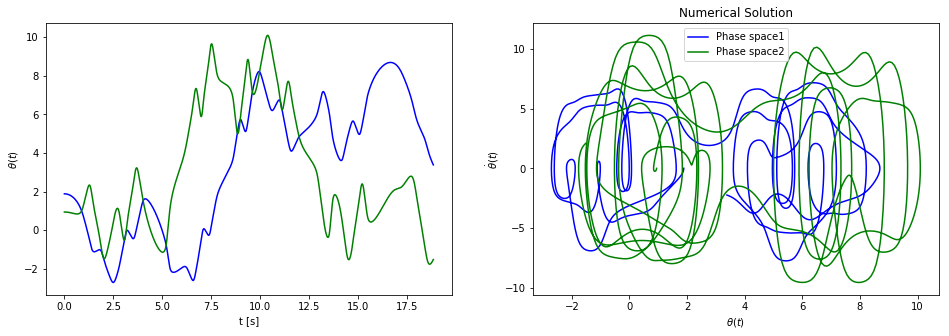

In [454]:
# Plot results

fig = plt.figure(figsize=(16,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.plot(t,theta[0,:],label="Real space1",color="b")
ax1.plot(t,theta[1,:],label="Real space2",color="g")

ax2.plot(theta[0,:],u[0,:],label="Phase space1",color="b")
ax2.plot(theta[1,:],u[1,:],label="Phase space2",color="g")

ax1.set_xlabel('t [s]'); ax1.set_ylabel(r'$\theta(t)$');
ax2.set_xlabel(r'$\theta(t)$'); ax2.set_ylabel(r'$\dot{\theta}(t)$');
plt.legend()
plt.title("Numerical Solution")
#plt.savefig("figures/doublePend.png")
plt.show()

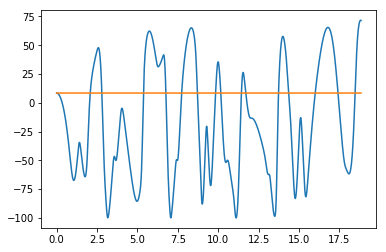

In [460]:
# Energy calculations

def energy(theta,u,L,g):
    # Potetial energy
    V = -0.5*L*g*(3*np.cos(theta[0]) + np.cos(theta[1]))
    
    T = (4*u[0]**2 + u[1]**2 + 3*u[0]*u[1]*np.cos(theta[0]-theta[1]))*L**2 / 6
    
    return T+V

E = energy(theta,u,params["L"],params["g"]) # Energy over time
E0 = energy(theta0,u0,params["L"],params["g"]) # Initial energy

plt.plot(t,E)
plt.plot(t,E0*np.ones(t.size))
plt.show()

In [456]:
# Visualize pendulum trajectory
# joint location -> (x1,y1) = (L*sin(th1),-L*cos(th1))
# end location   -> (x2,y2) = (x1,y1) + L*(sin(th2),-cos(th2))       
def animate(theta):
    x1 = L*np.sin(theta[0]); y1 = -L*np.cos(theta[0]);
    x2 = x1 + L*np.sin(theta[1]); y2 = y1 - L*np.cos(theta[1]);
    x = [0,x1,x2]
    y = [0,y1,y2]
    line.set_data(x,y)
    
    return line,

L = params["L"]

fig = plt.figure()
ax = plt.axes(xlim=(-2*L,2*L),ylim=(-2*L,2*L))
line, = ax.plot([],[],lw=2)

anim = animation.FuncAnimation(fig,animate,frames=np.transpose(theta),interval=10,blit=True)
display_animation(anim,default_mode='loop')

KeyboardInterrupt: 


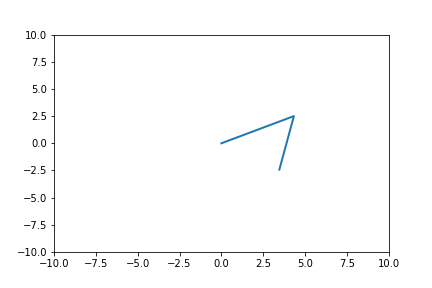
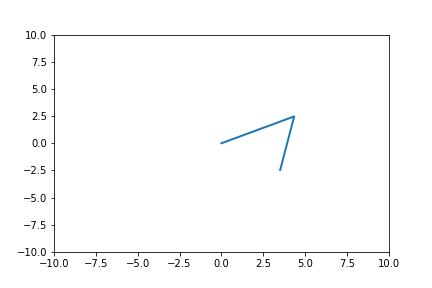
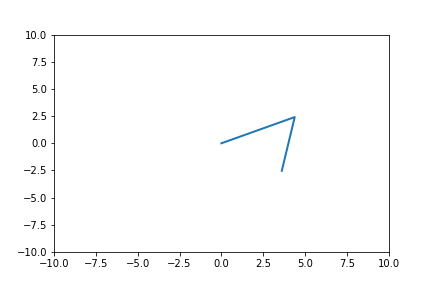
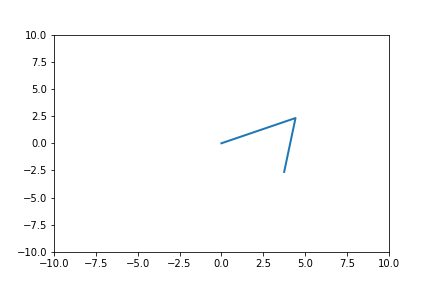
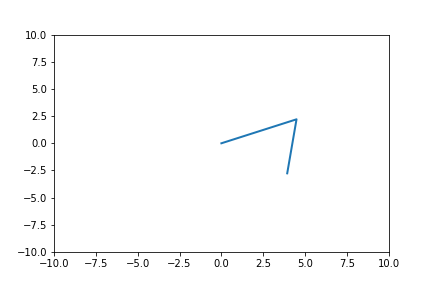
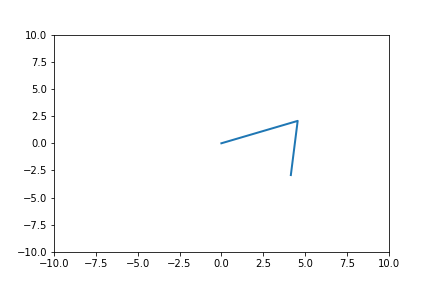
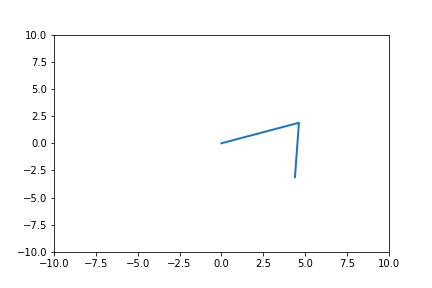
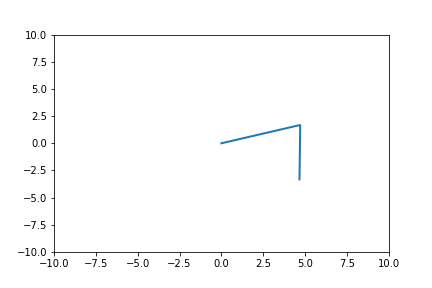
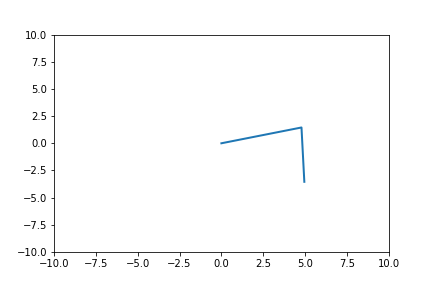
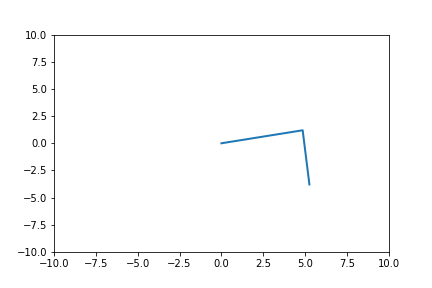
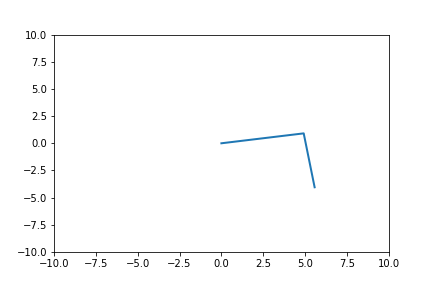
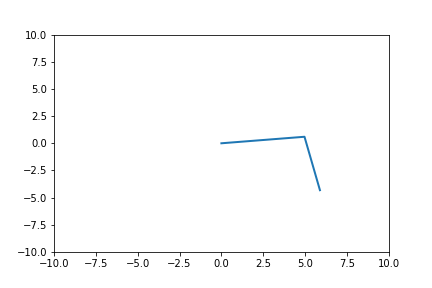
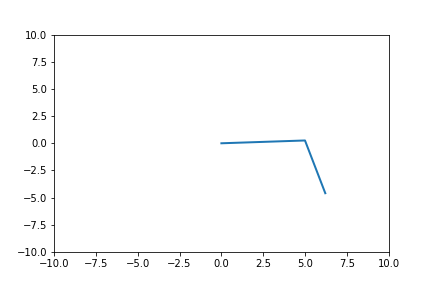
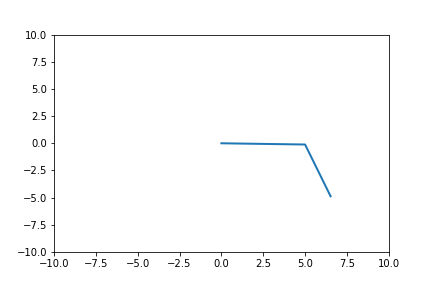
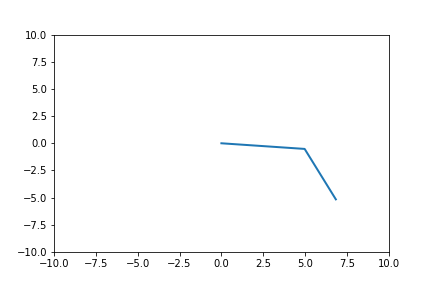
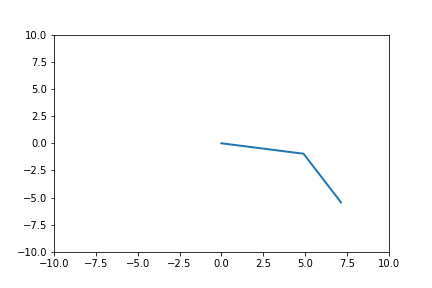
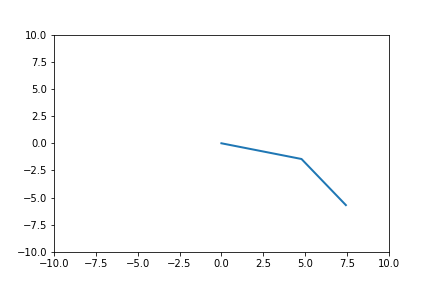
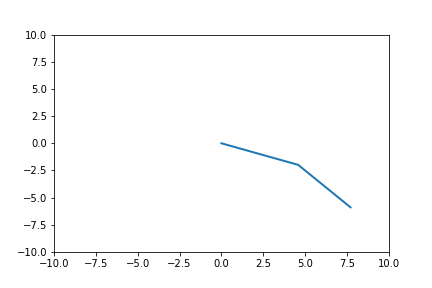
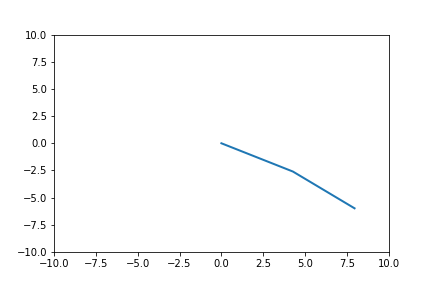
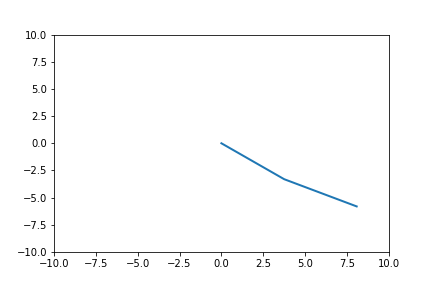
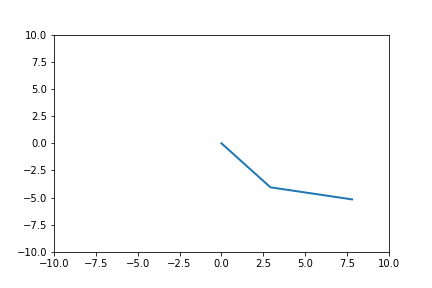
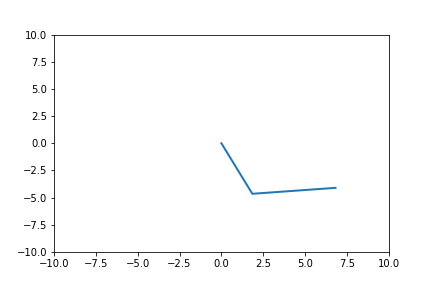
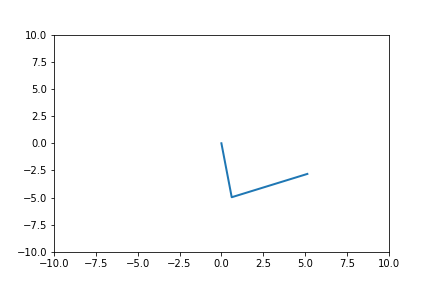
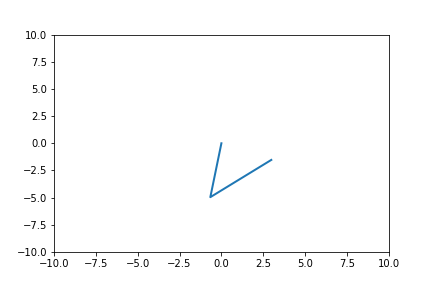
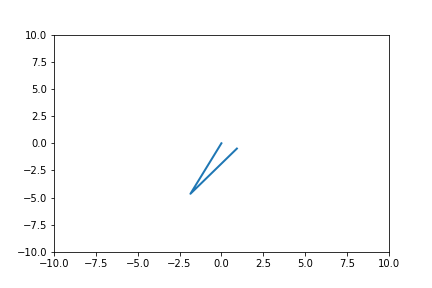
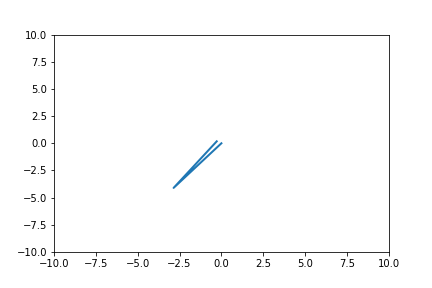
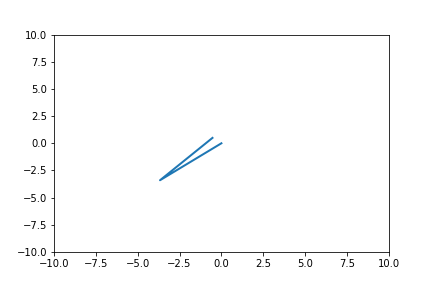
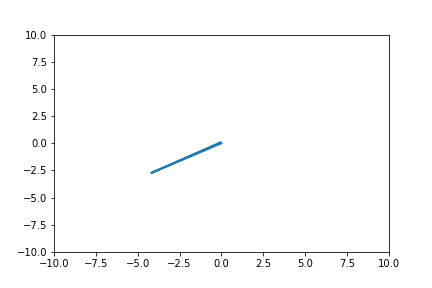
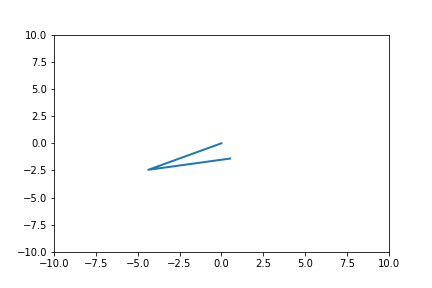
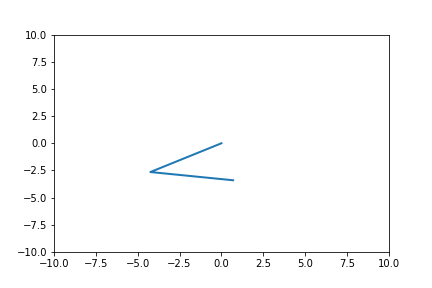
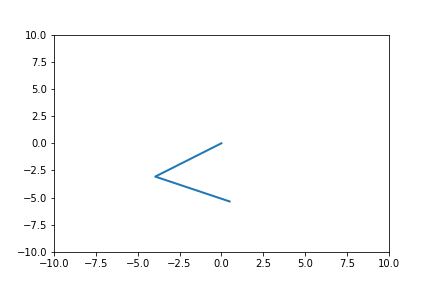
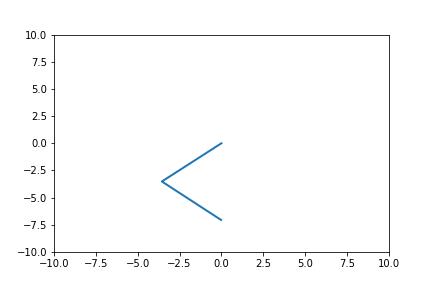
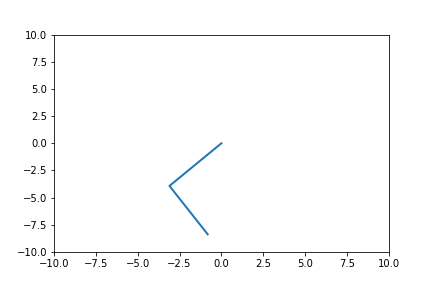
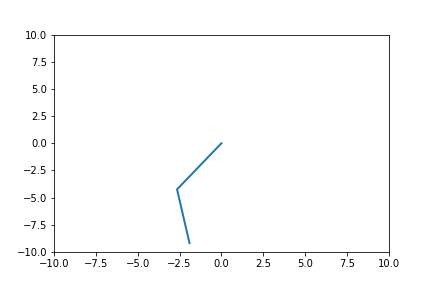
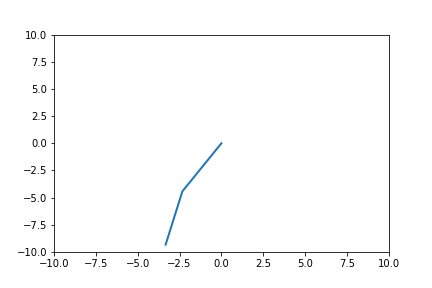
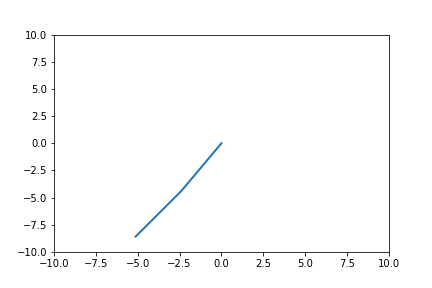
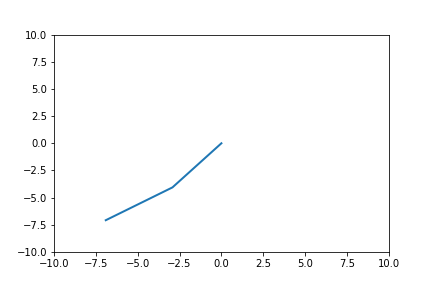
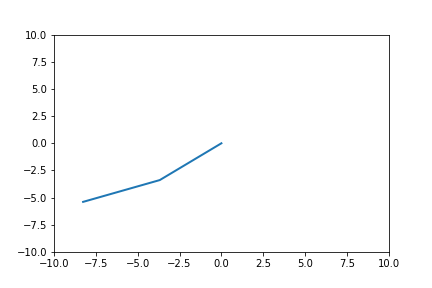
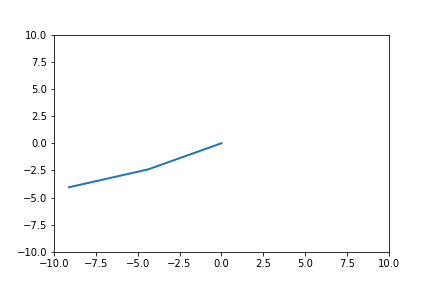
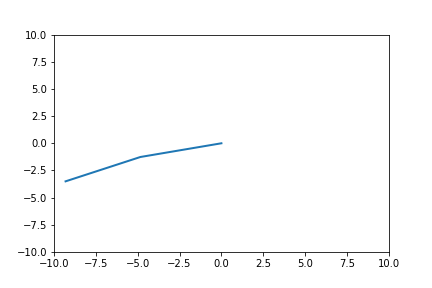
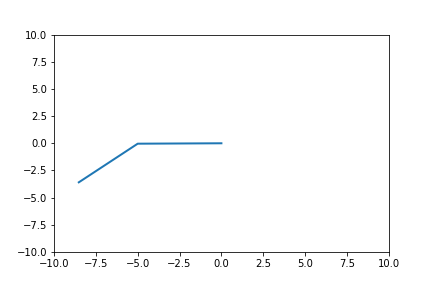
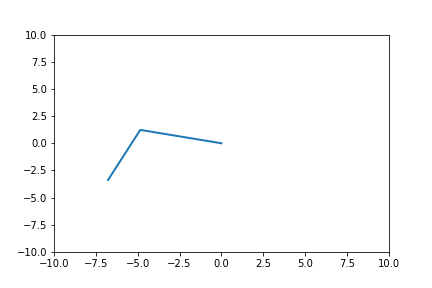
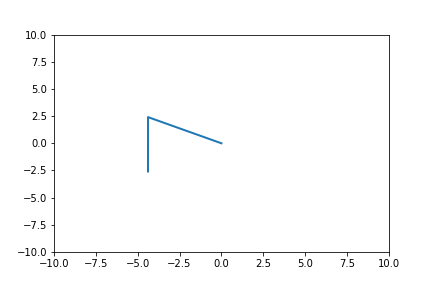
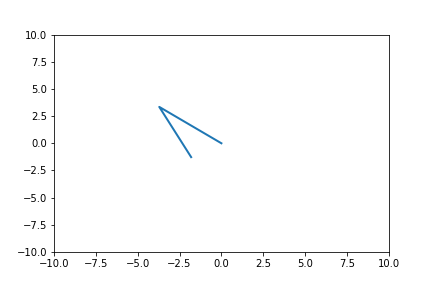
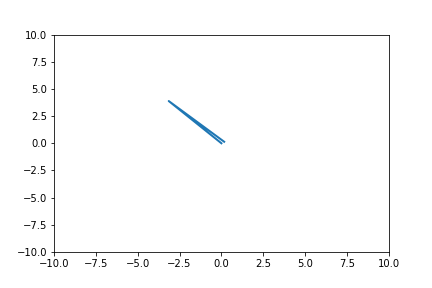
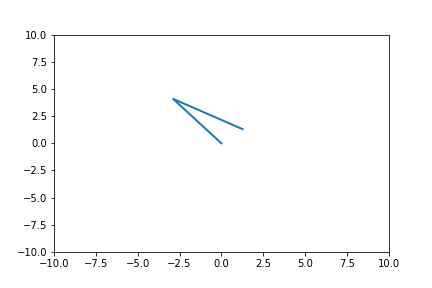
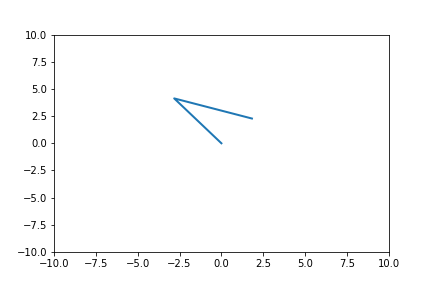
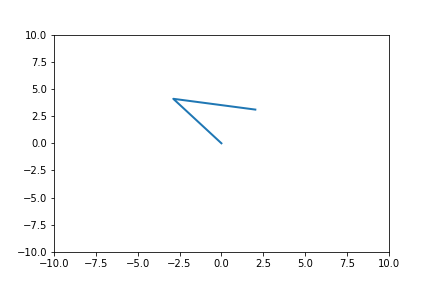
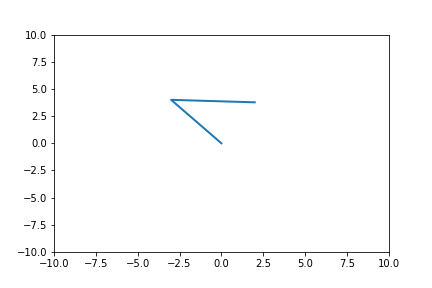
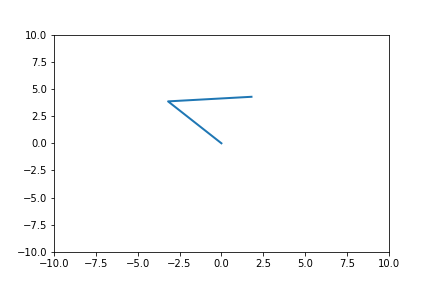
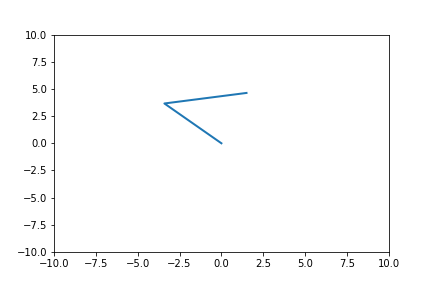
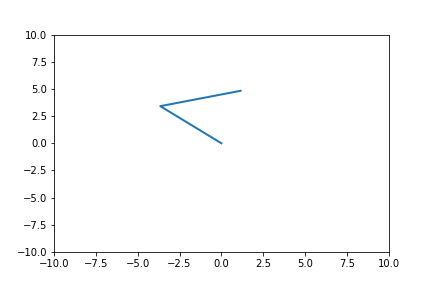
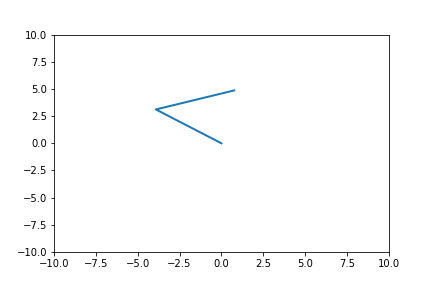
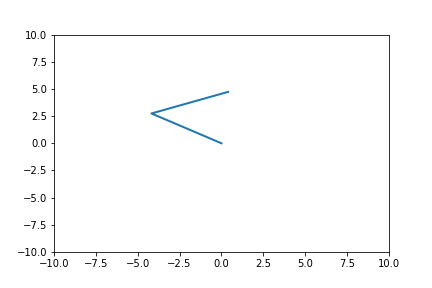
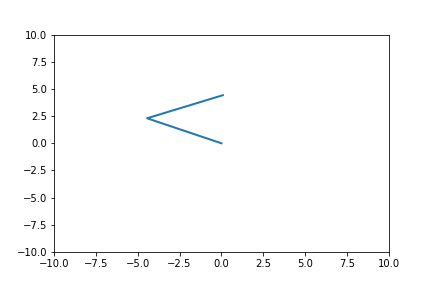
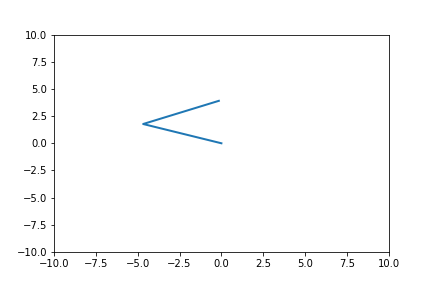
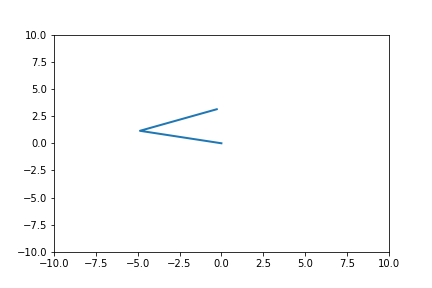
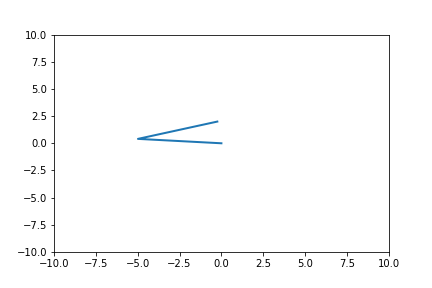
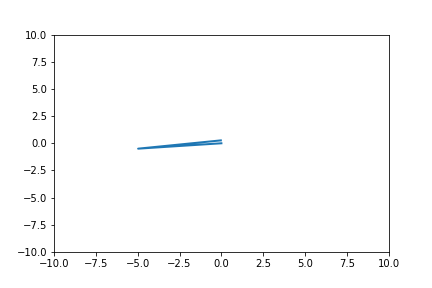
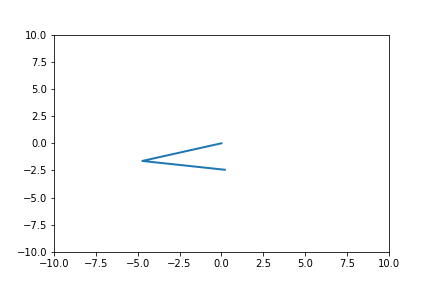
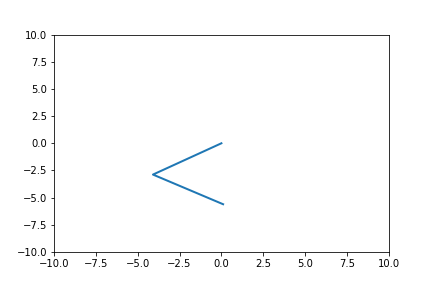
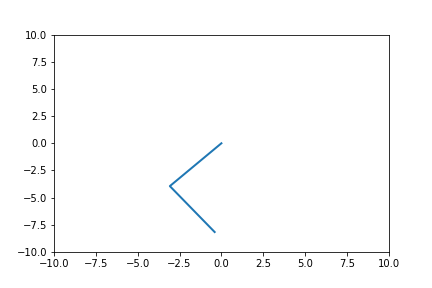
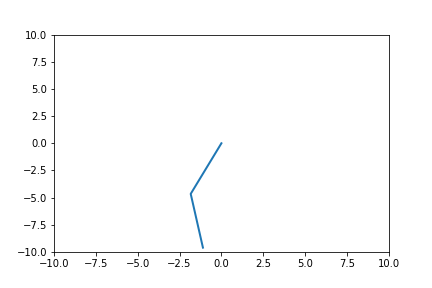
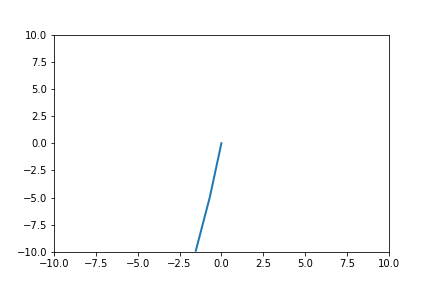
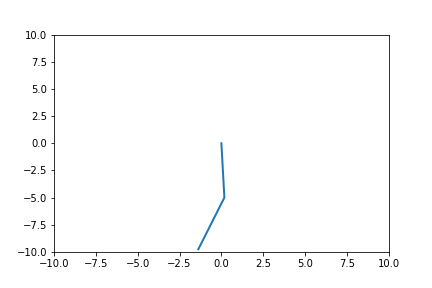
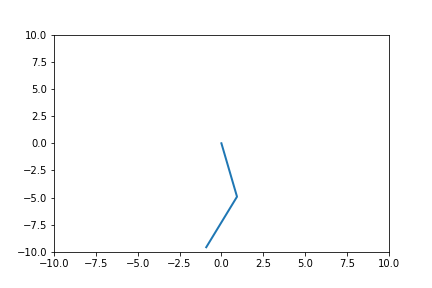
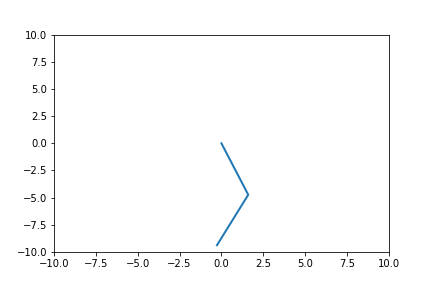
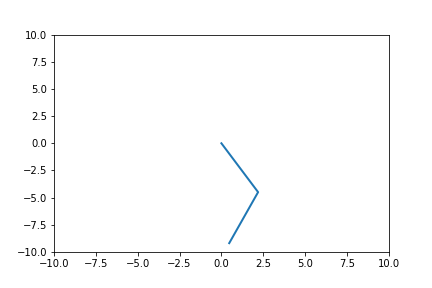
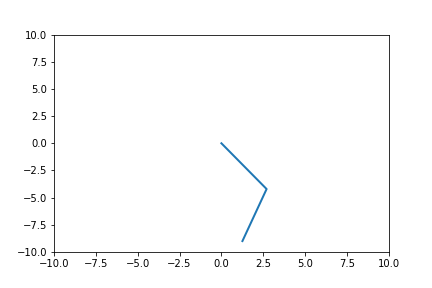
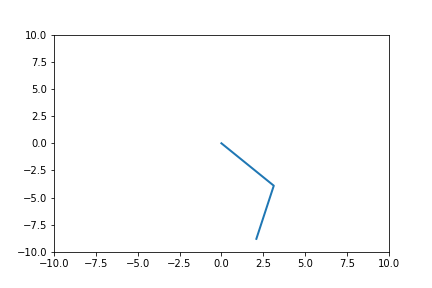
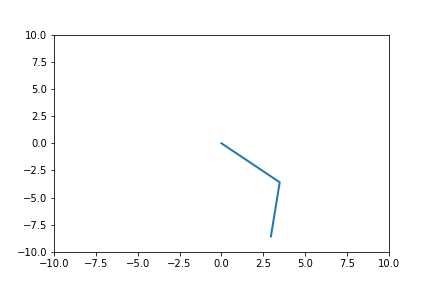
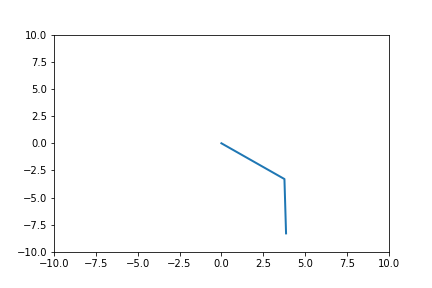
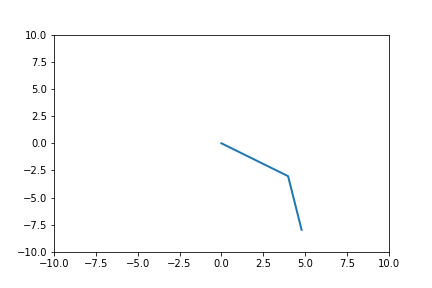
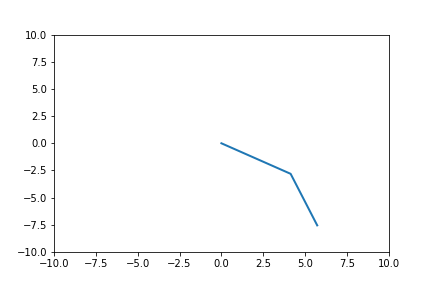
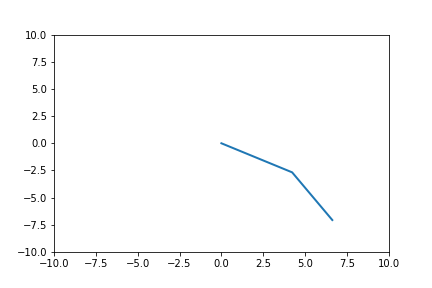
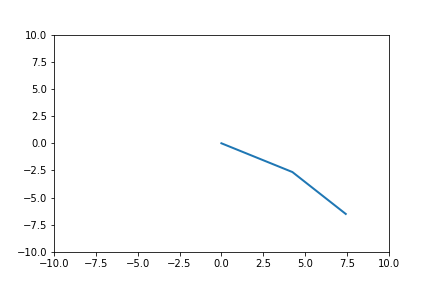
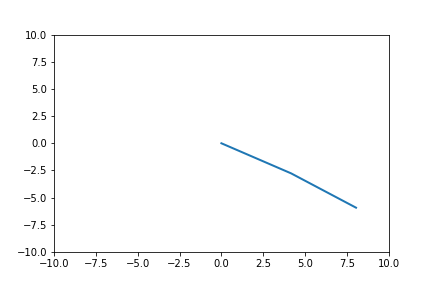
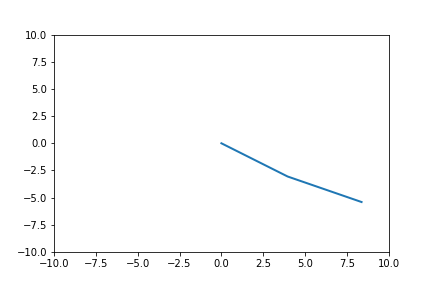
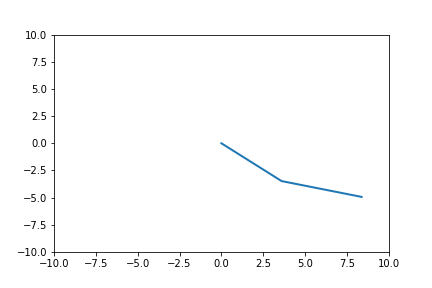
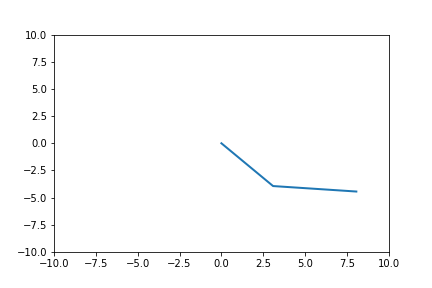
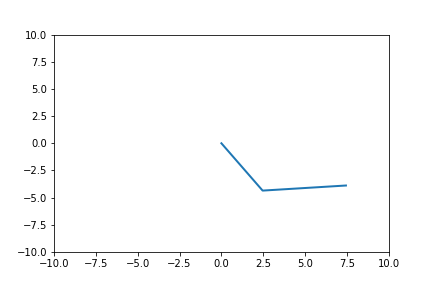
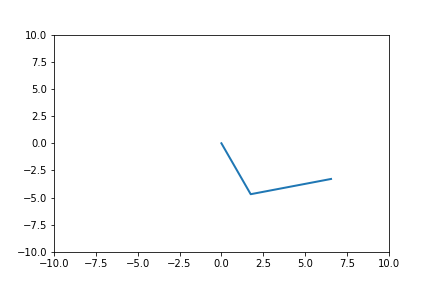
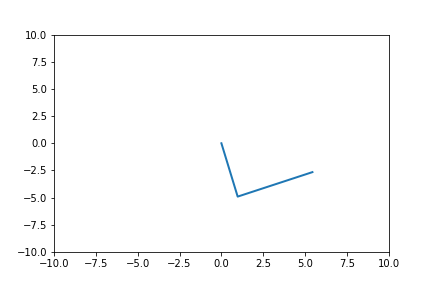
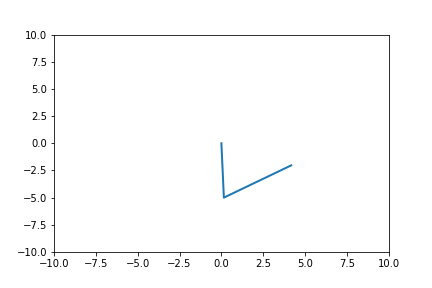
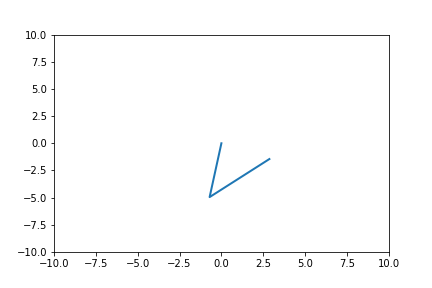
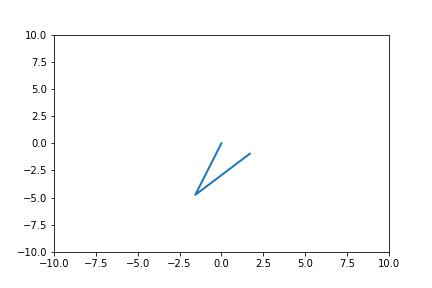
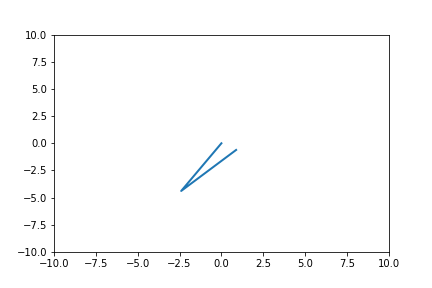
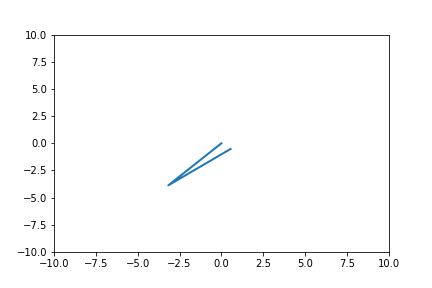
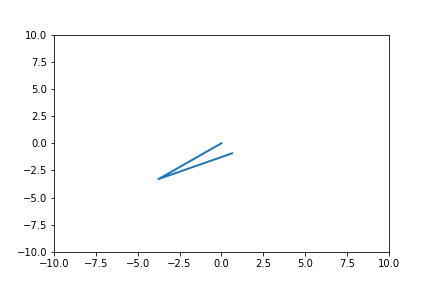
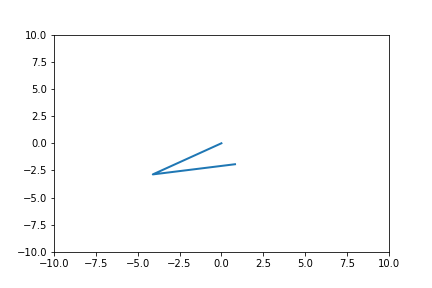
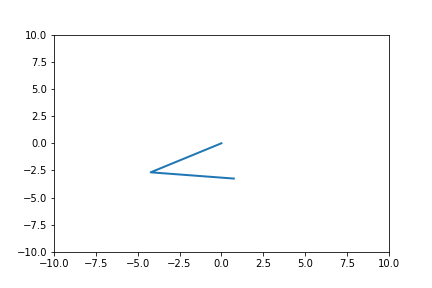
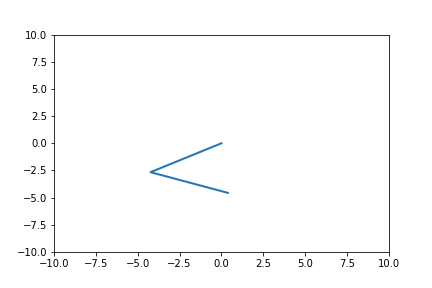
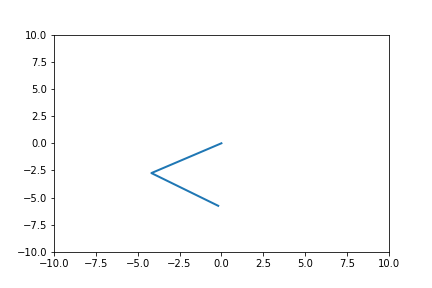
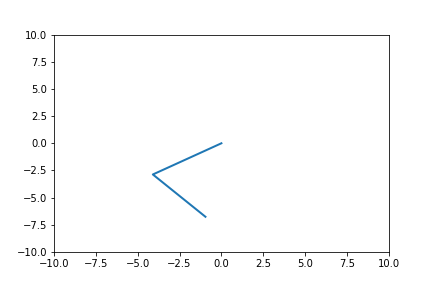
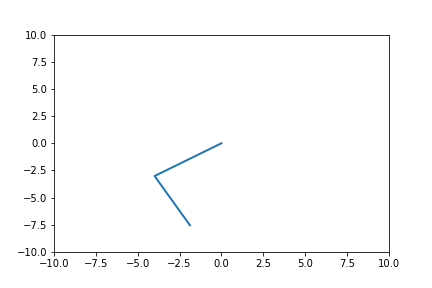
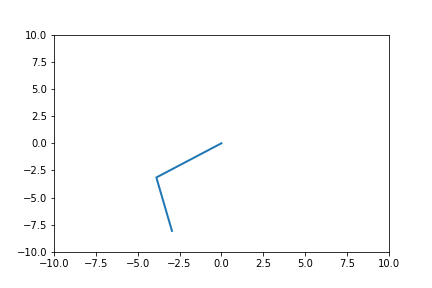
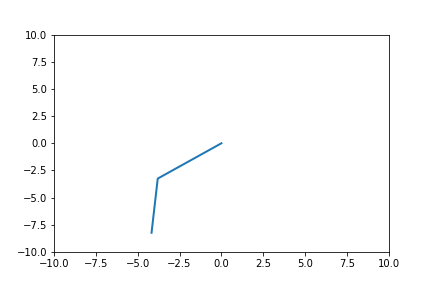
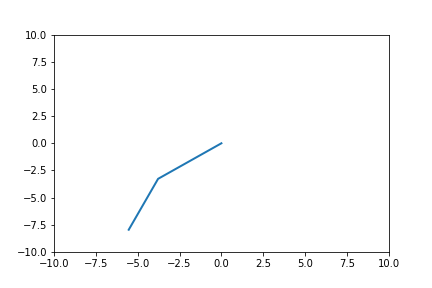
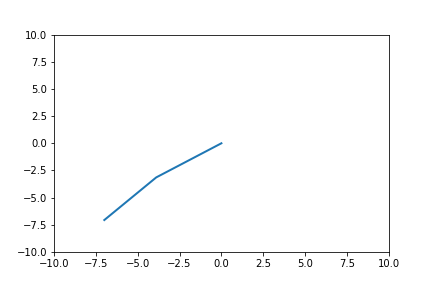
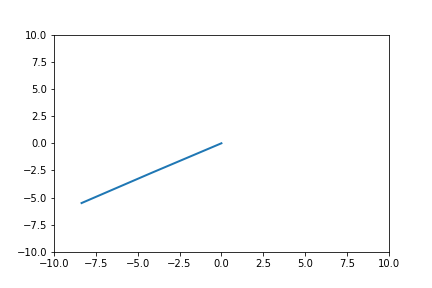
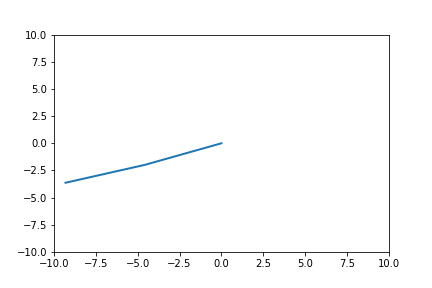
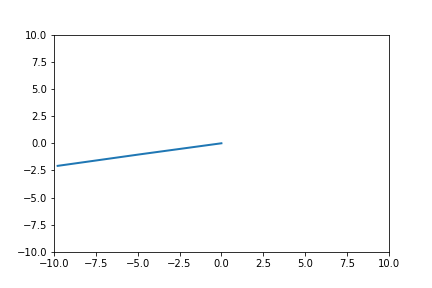
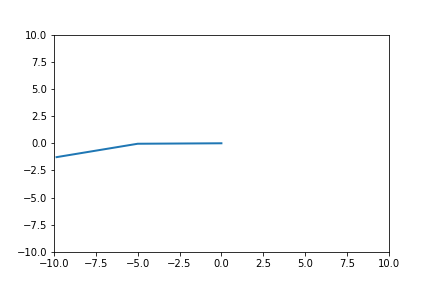
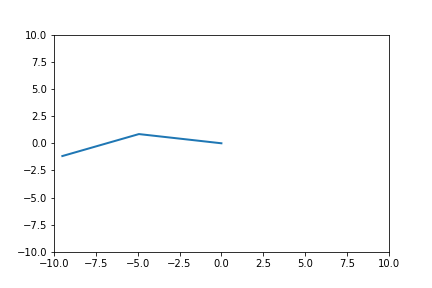
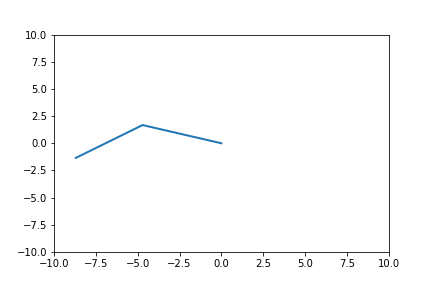
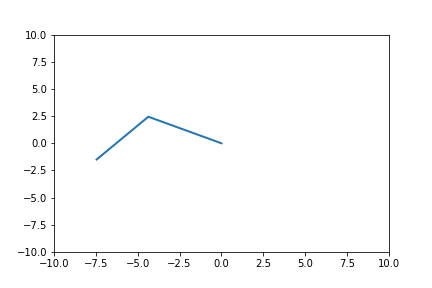
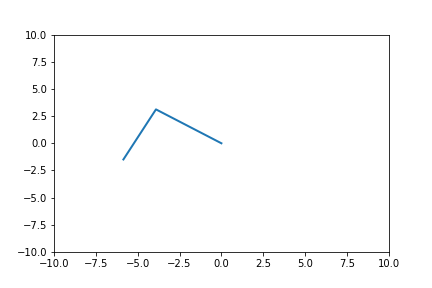
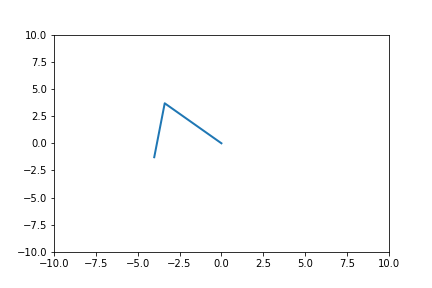
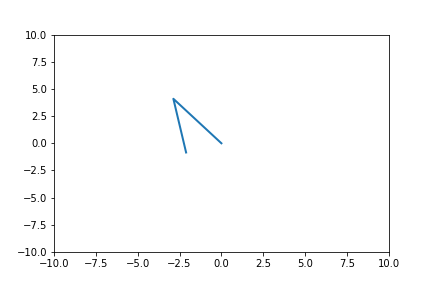
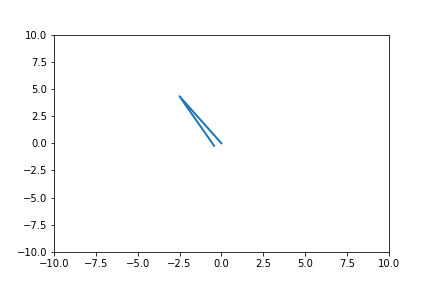
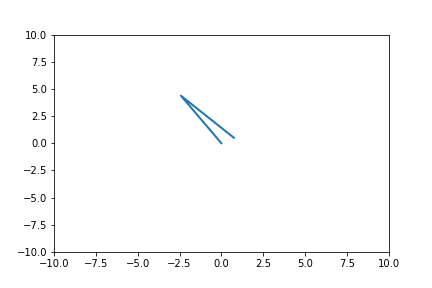
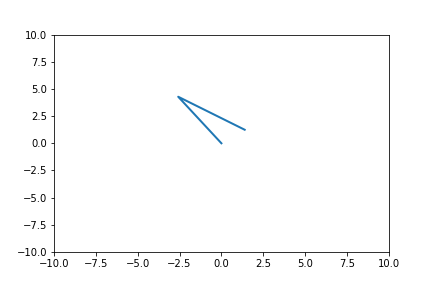
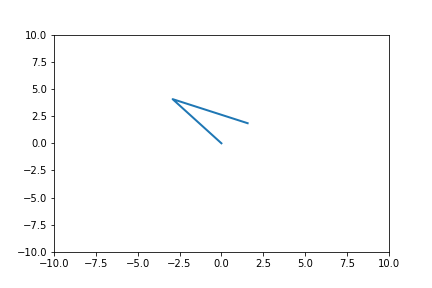
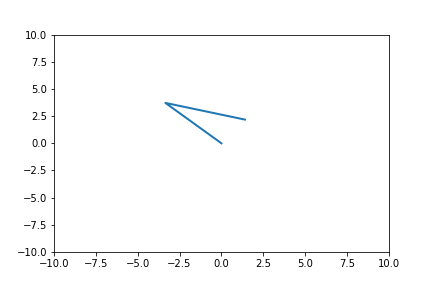
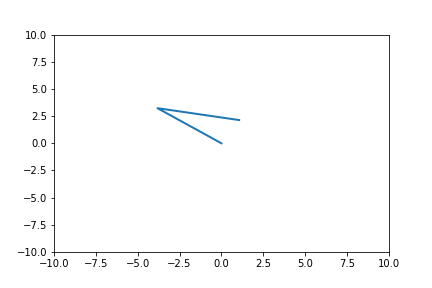
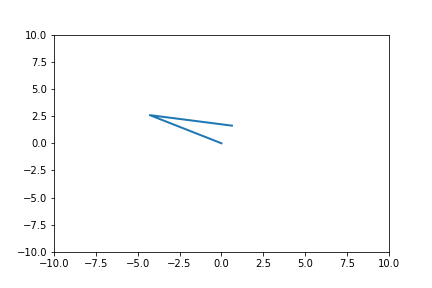
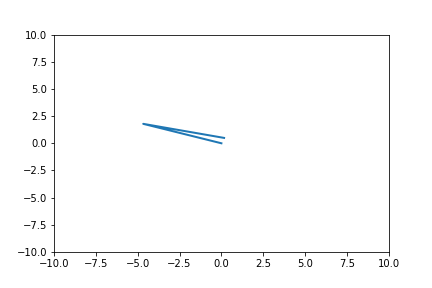
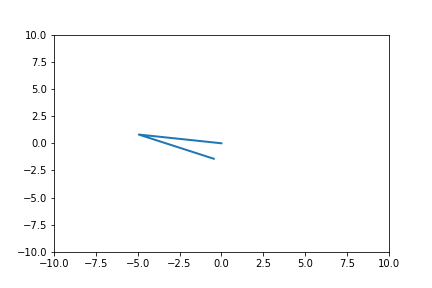
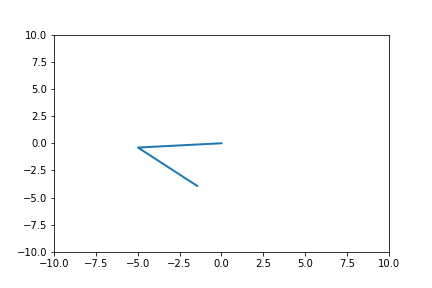
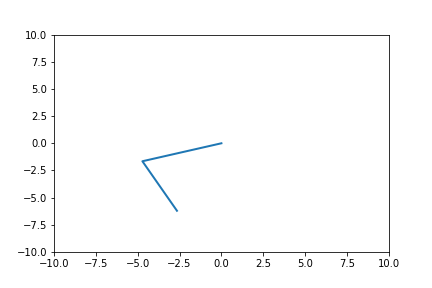
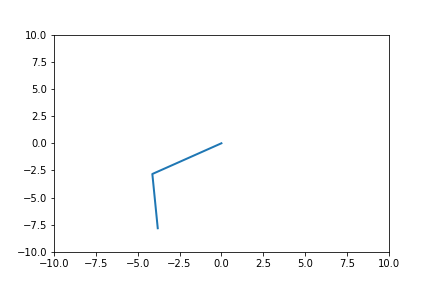
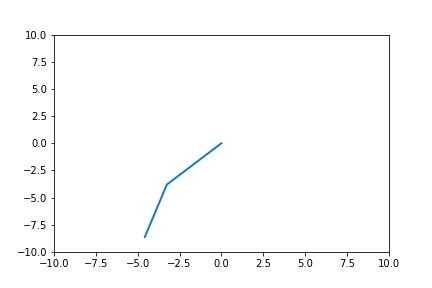
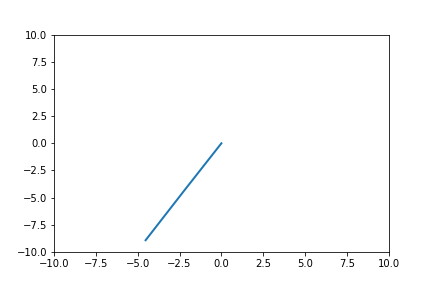
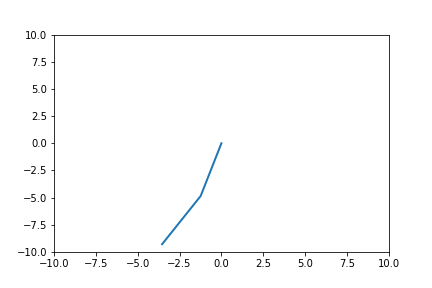
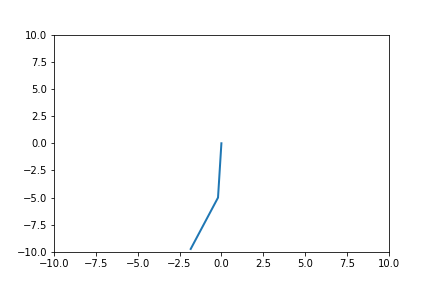
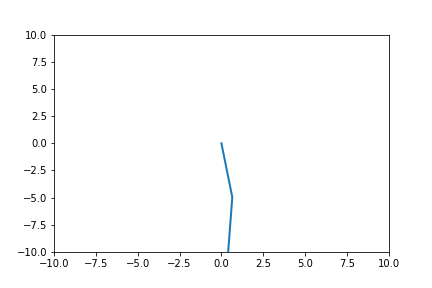
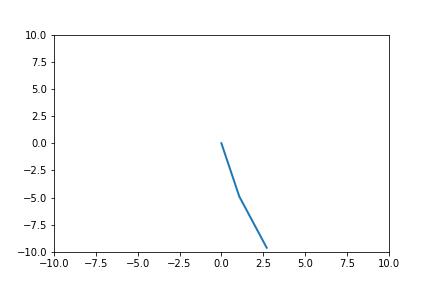
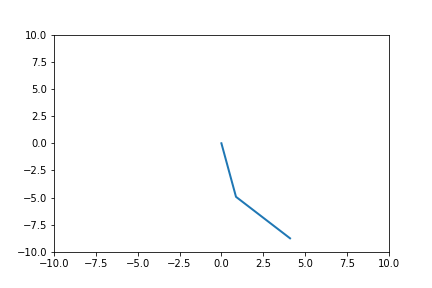
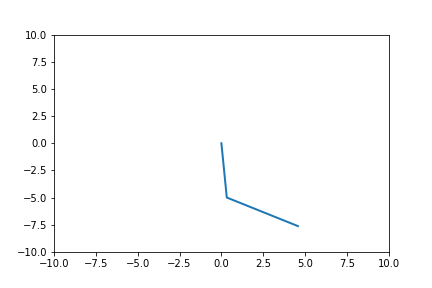
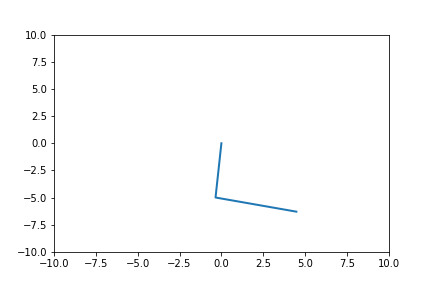
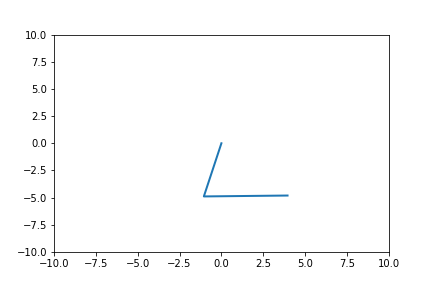
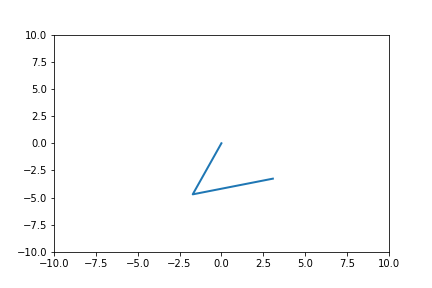
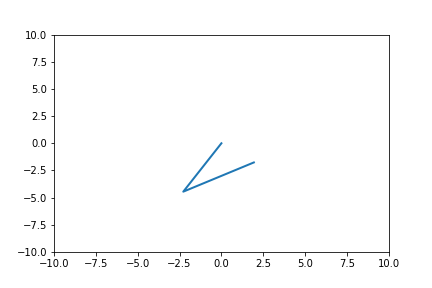
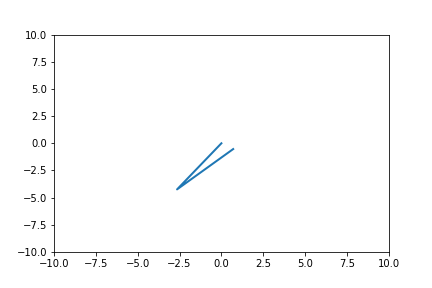
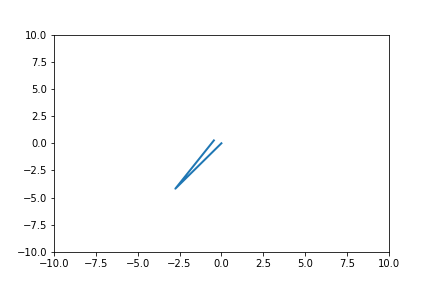
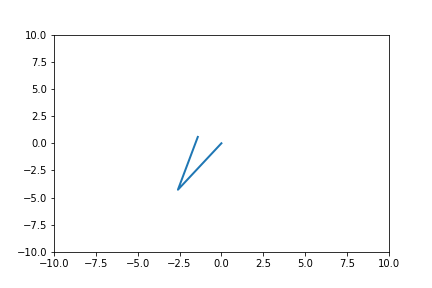
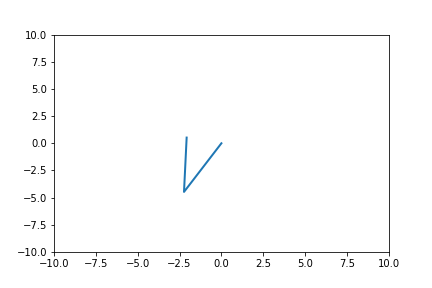
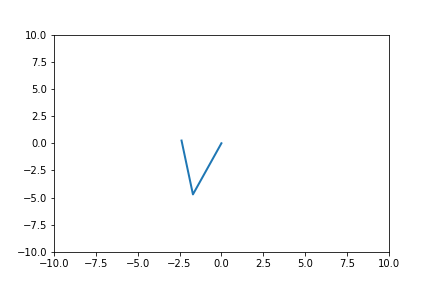
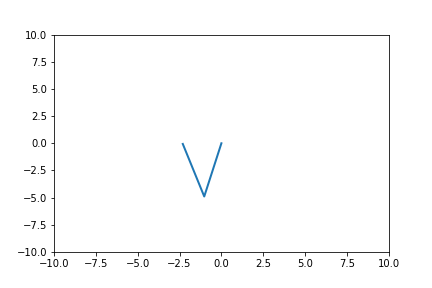
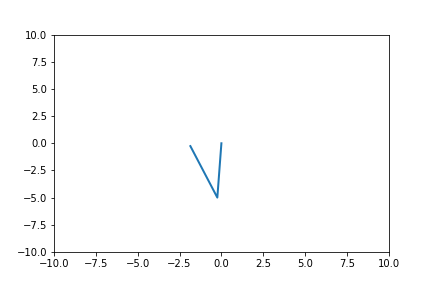
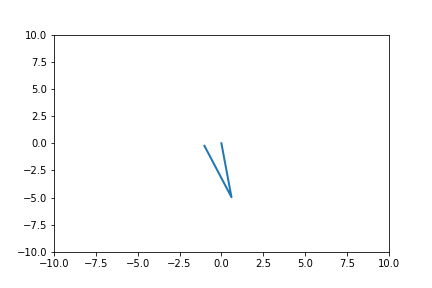
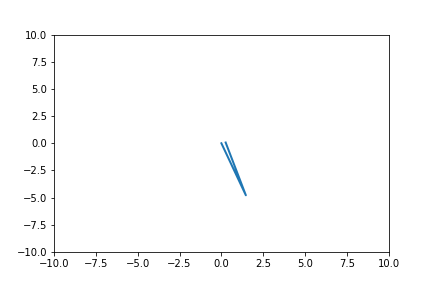
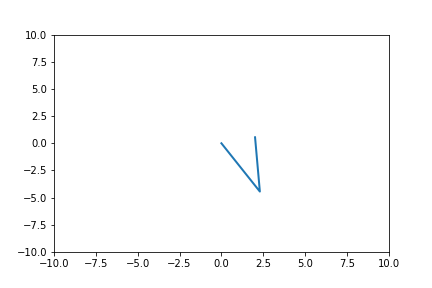
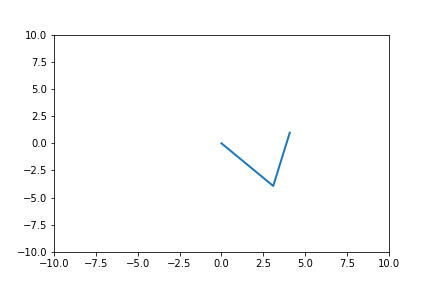
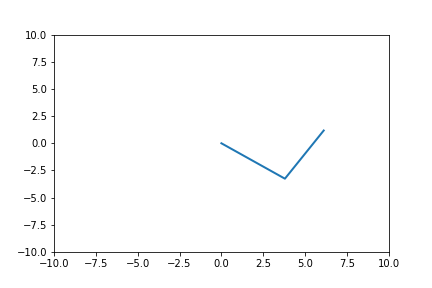
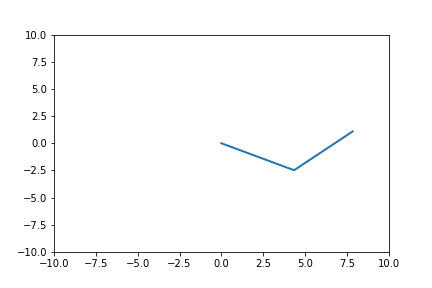
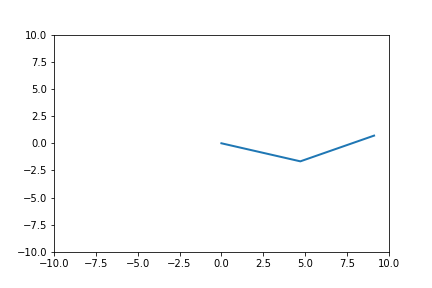
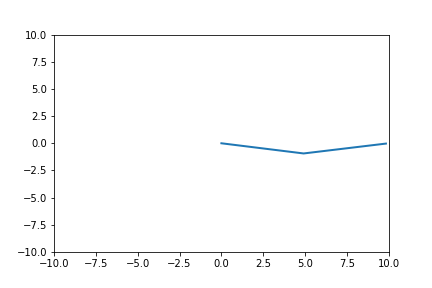
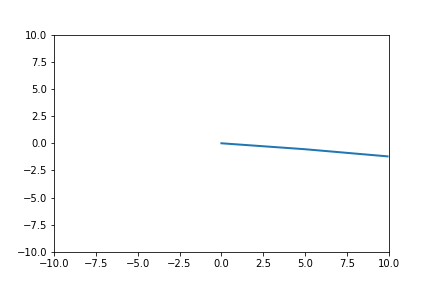
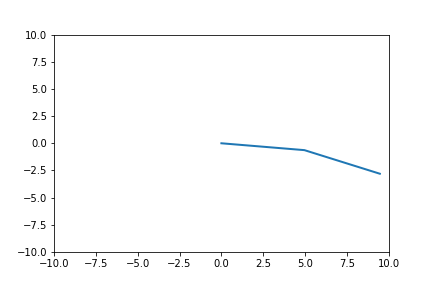
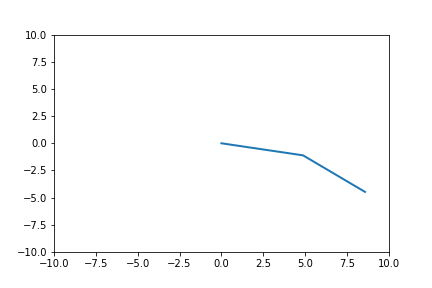
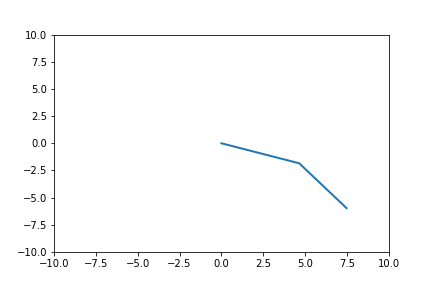
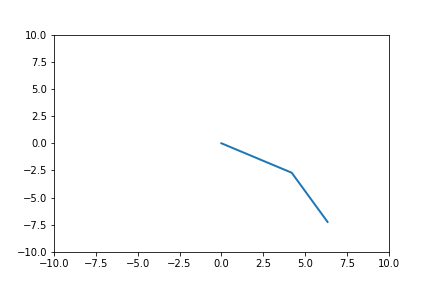
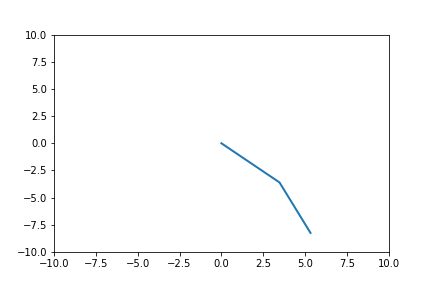
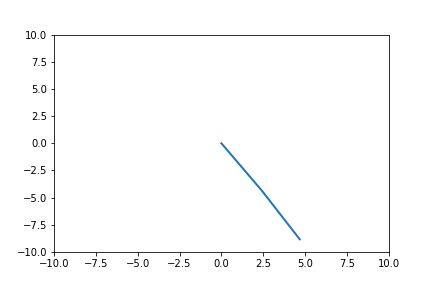
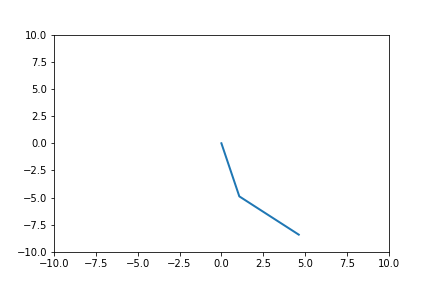
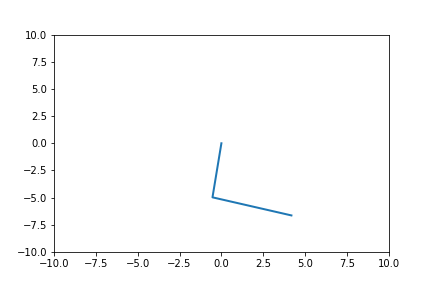
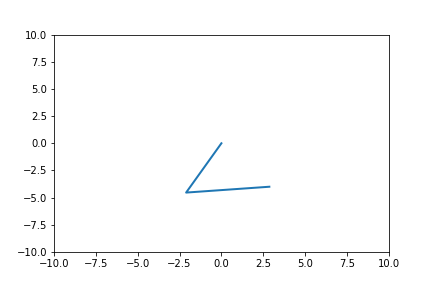
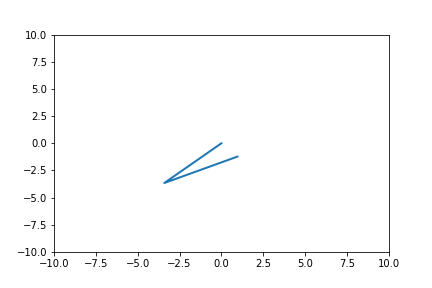
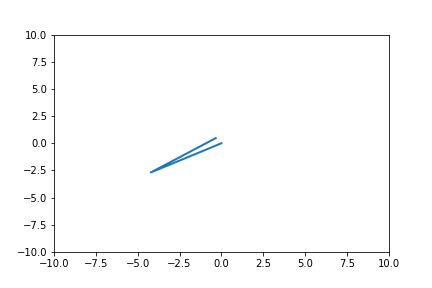
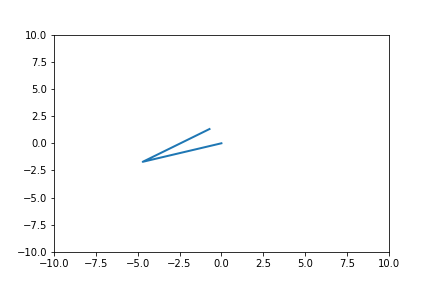
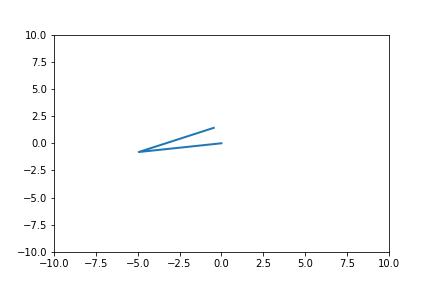
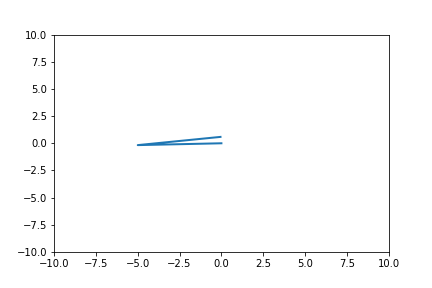
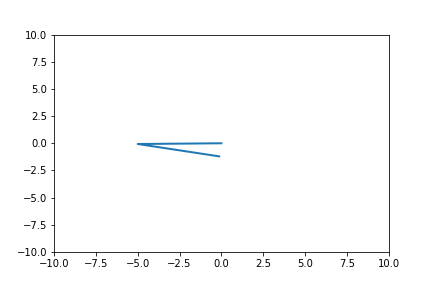
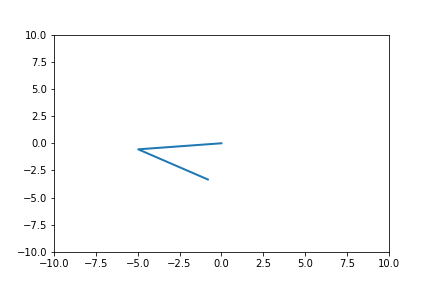
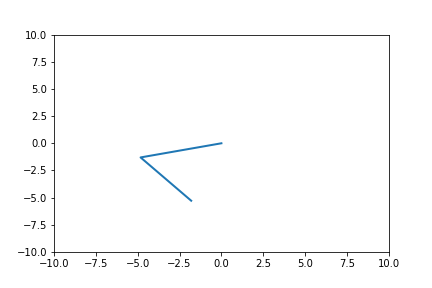
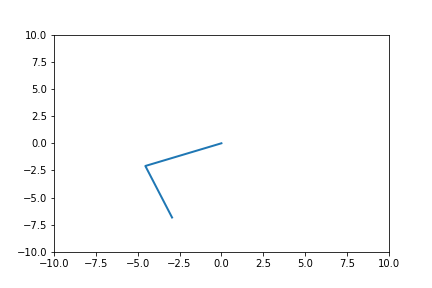
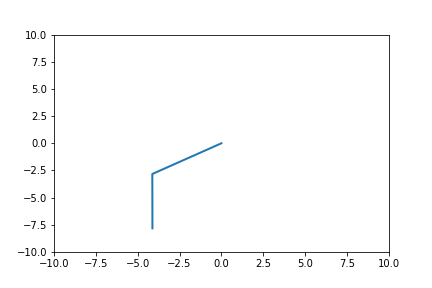
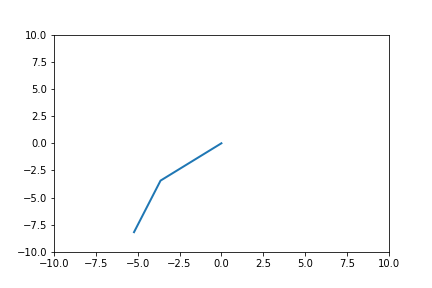
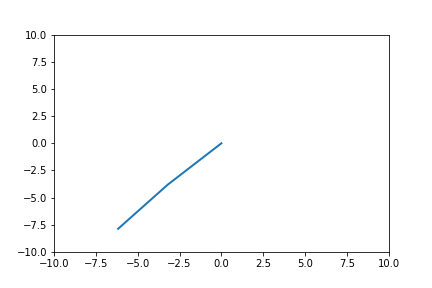
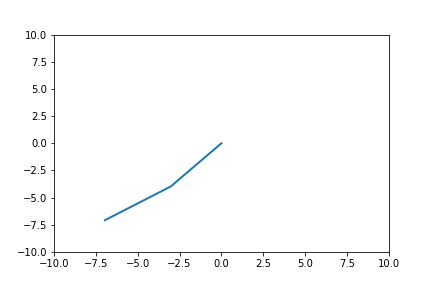
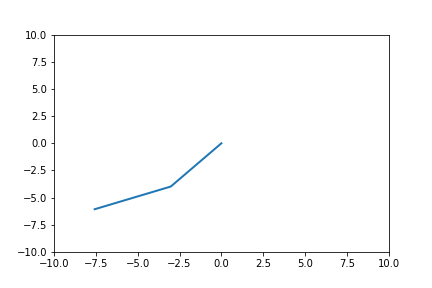
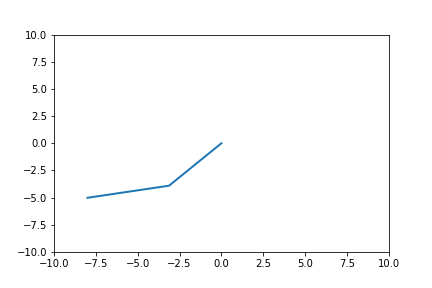
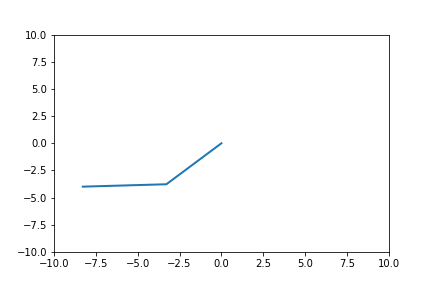
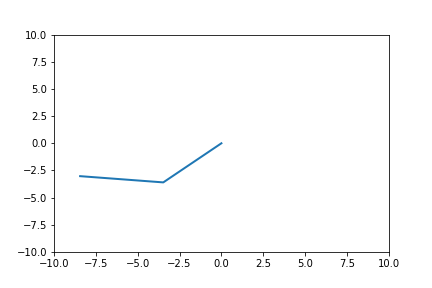
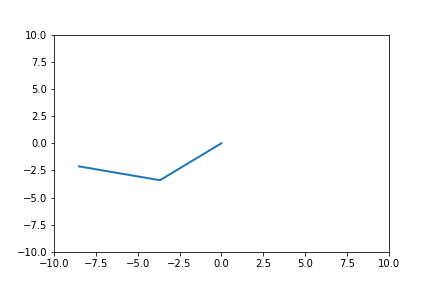
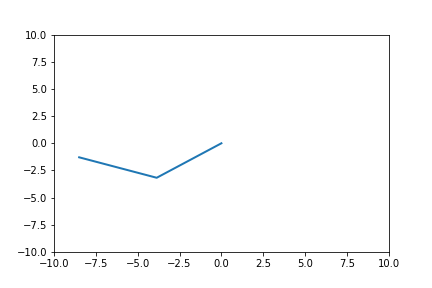
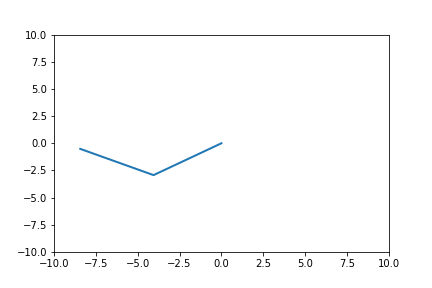
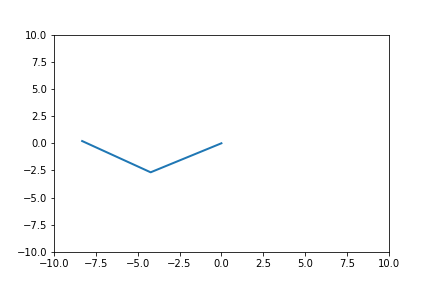
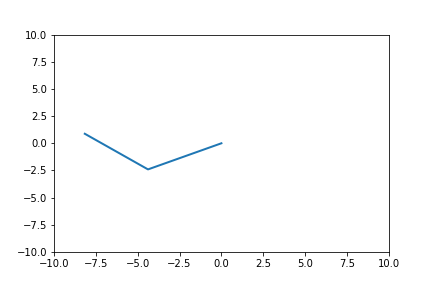
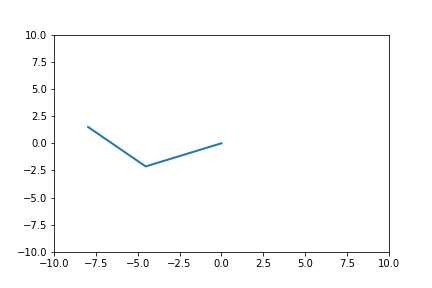
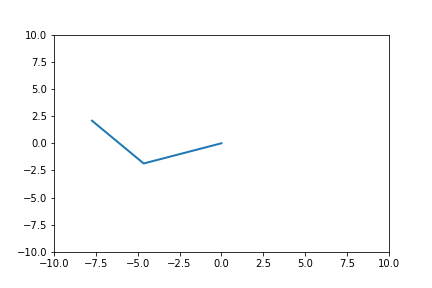
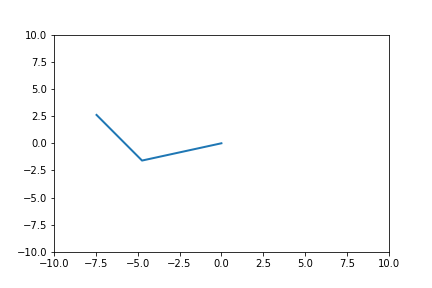
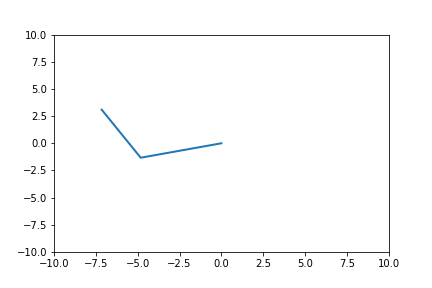
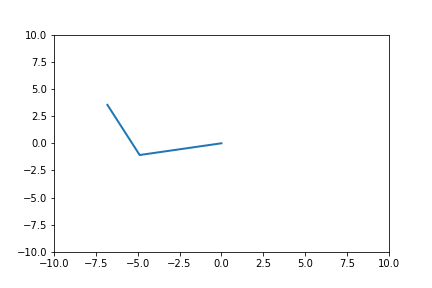
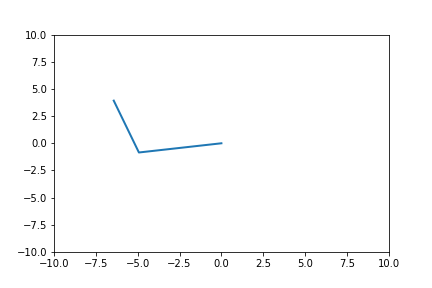
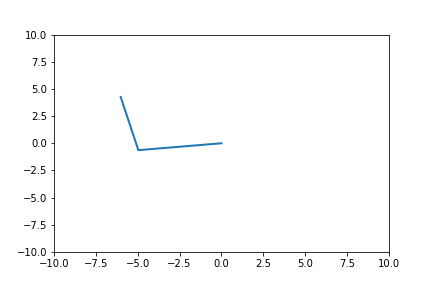
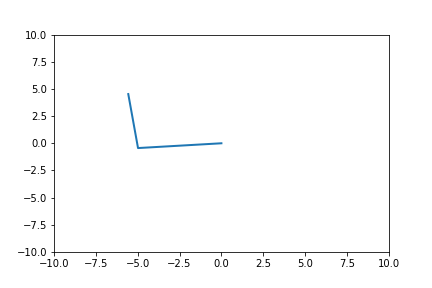
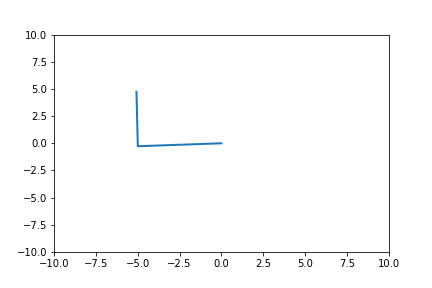
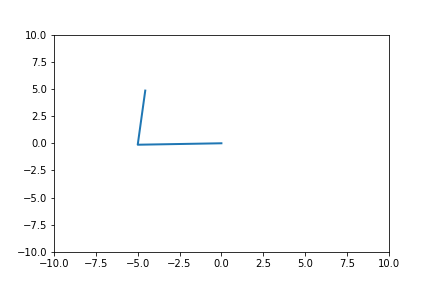
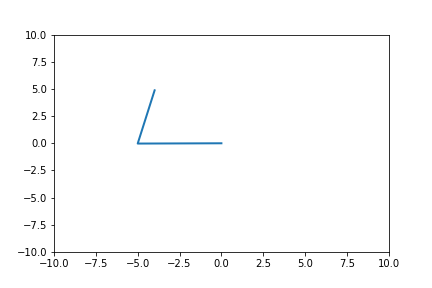
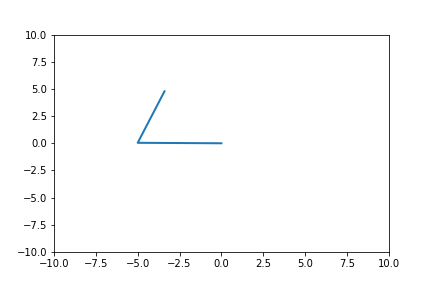
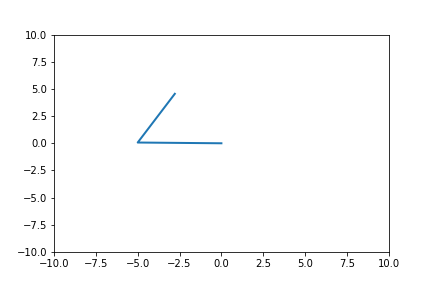
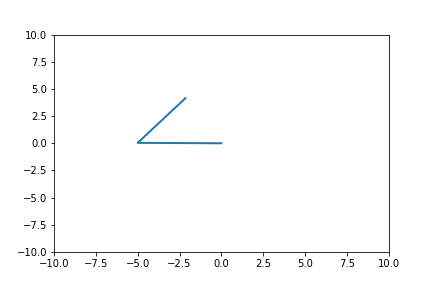
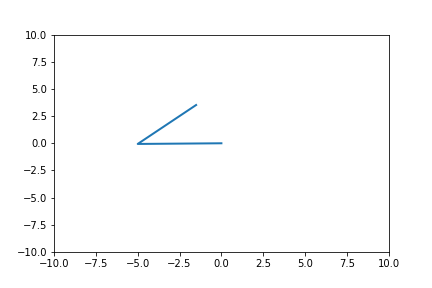
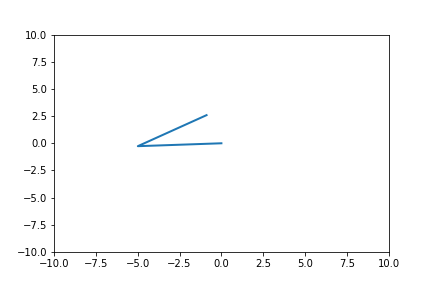
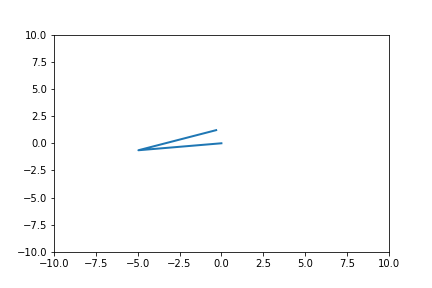
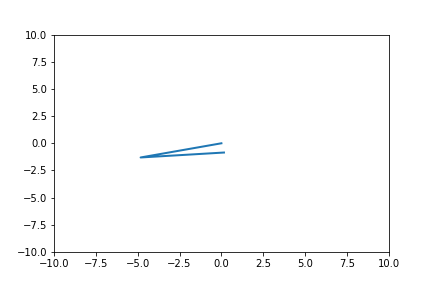
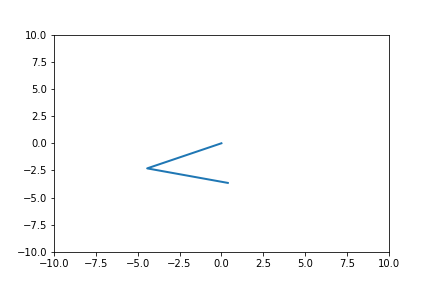
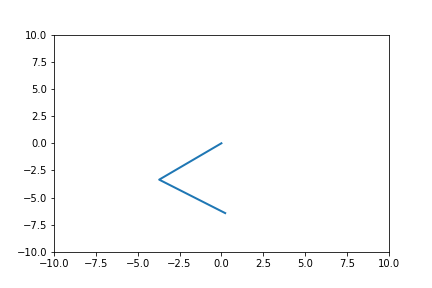
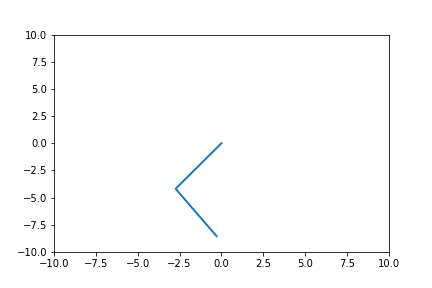
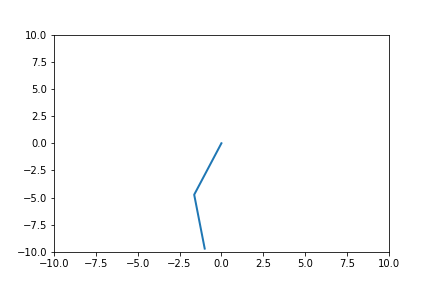
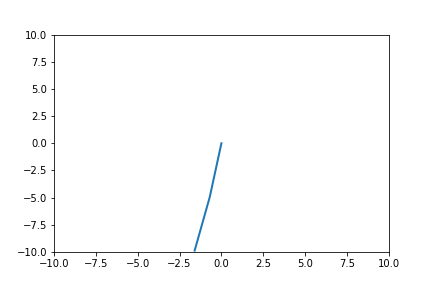
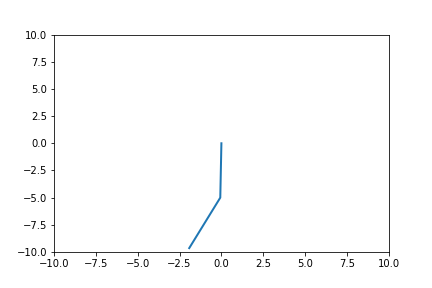
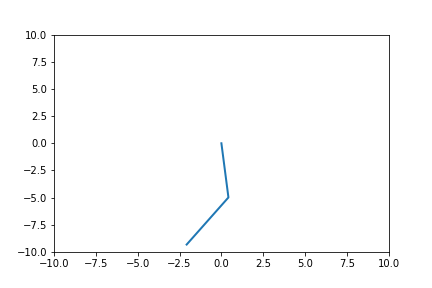
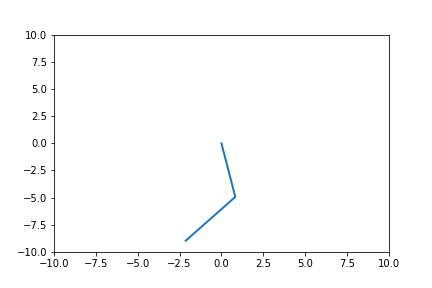
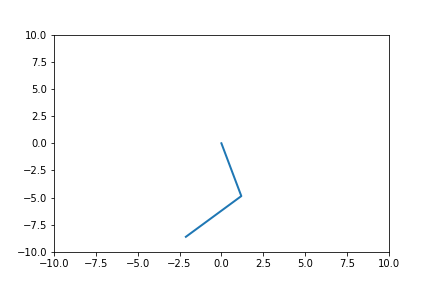
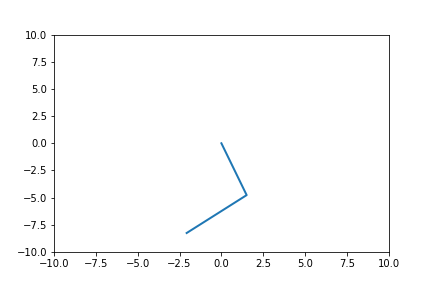
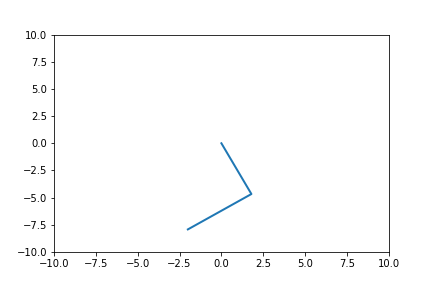
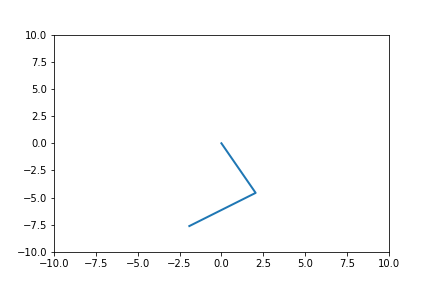
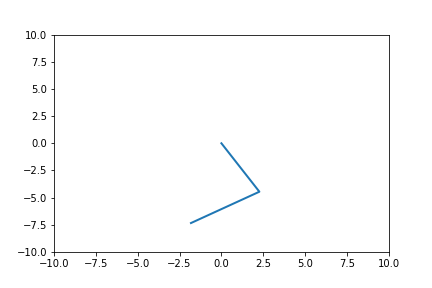
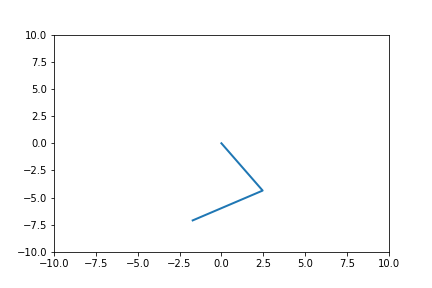
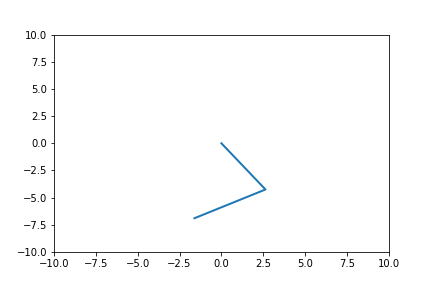
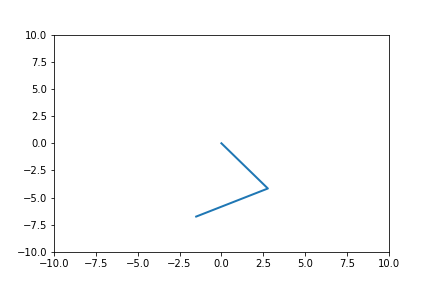
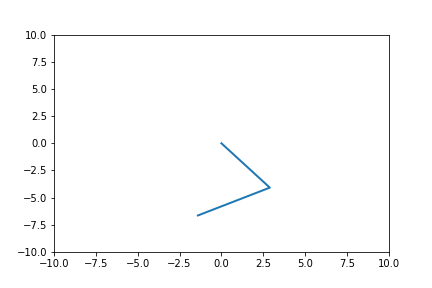
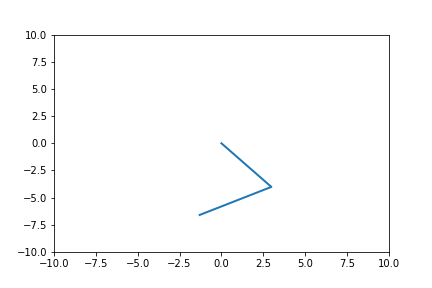
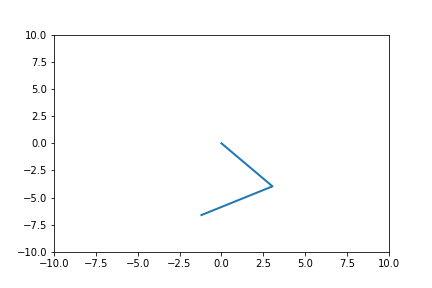
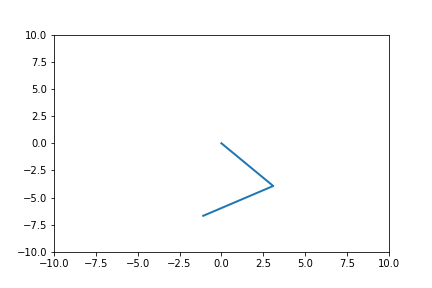
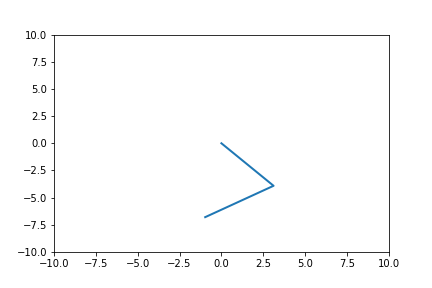
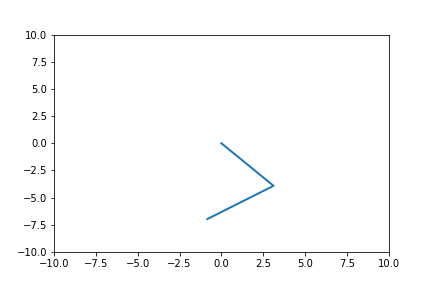
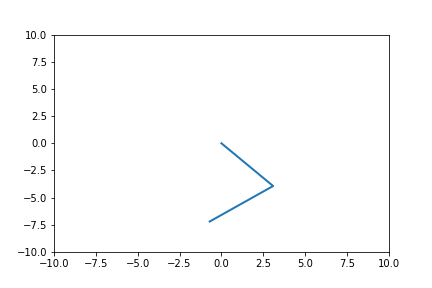
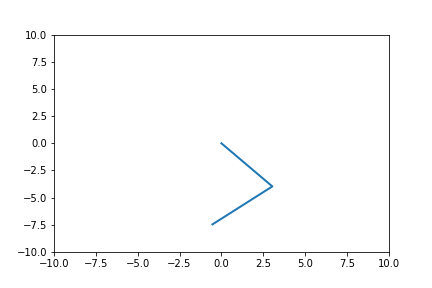
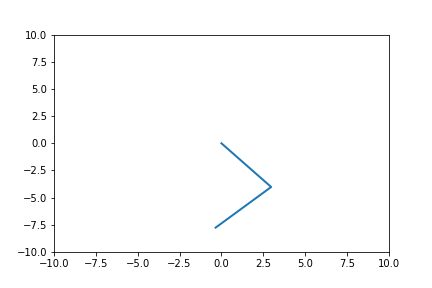
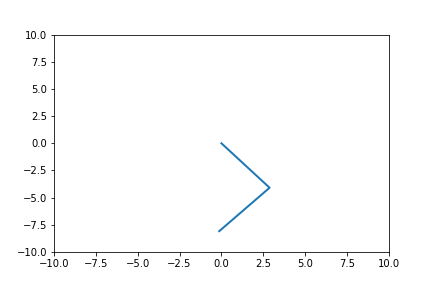
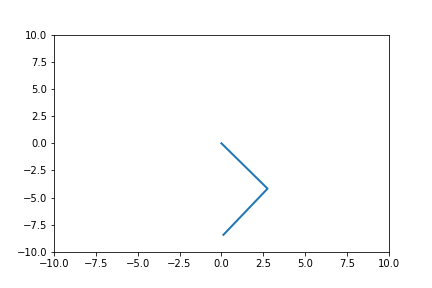
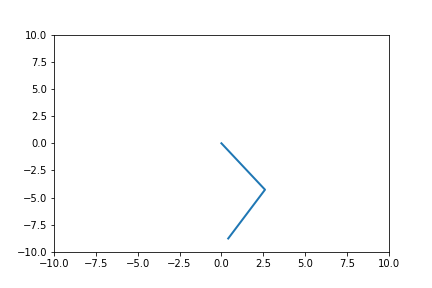
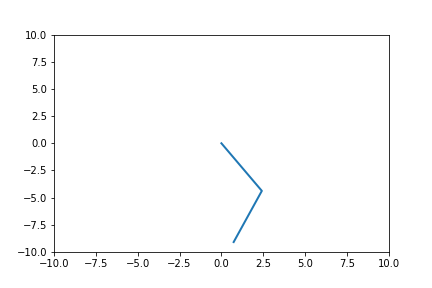
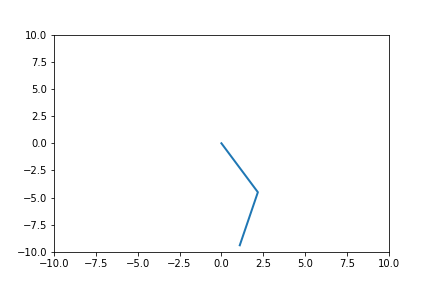
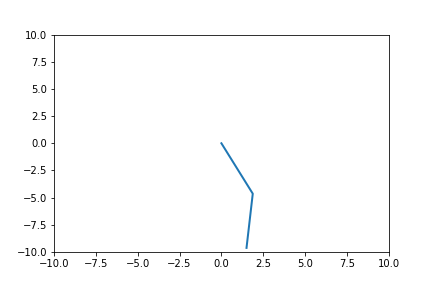
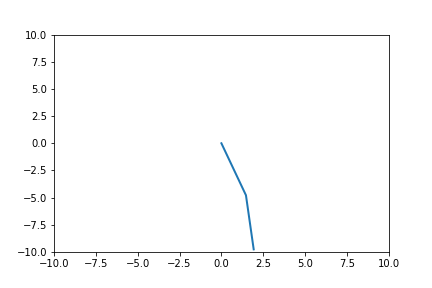
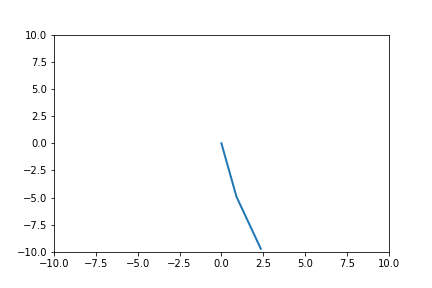
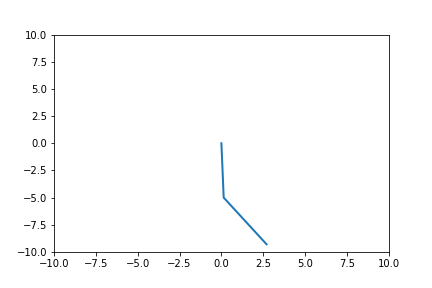
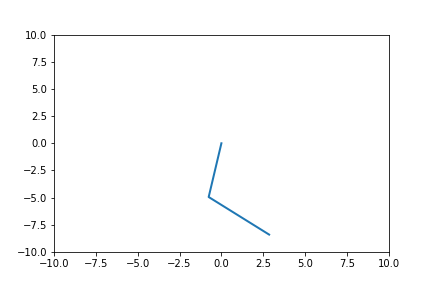
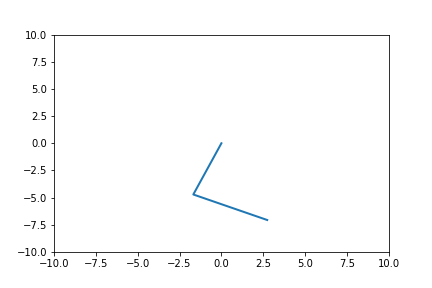
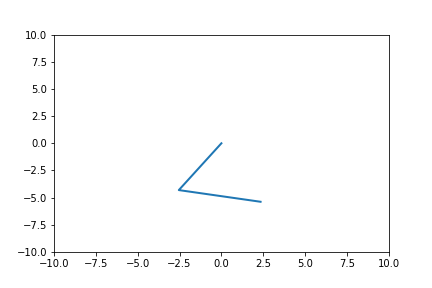
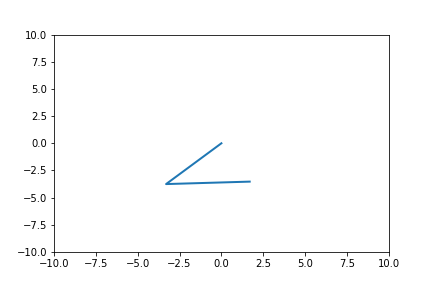
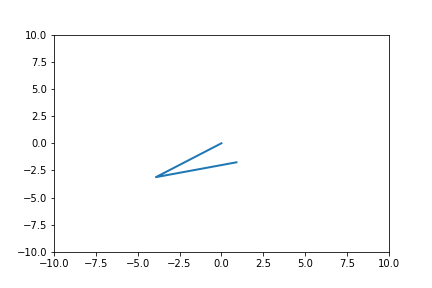
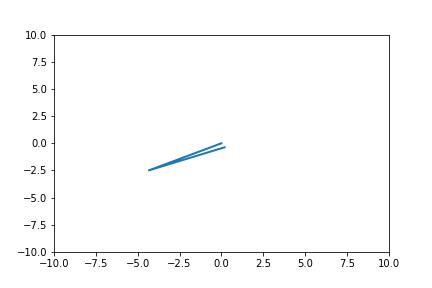
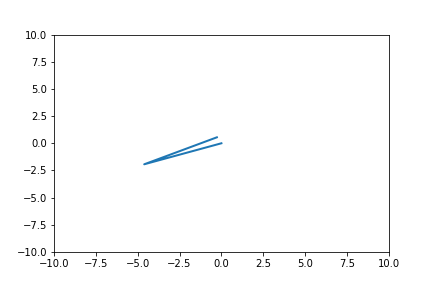
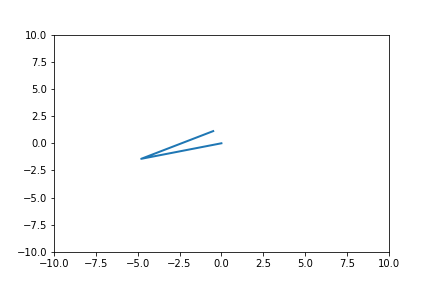
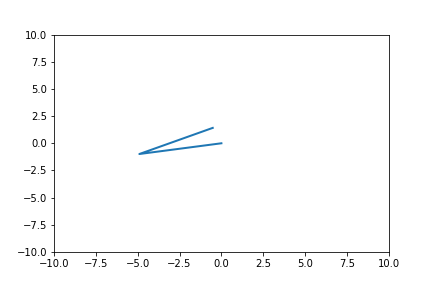
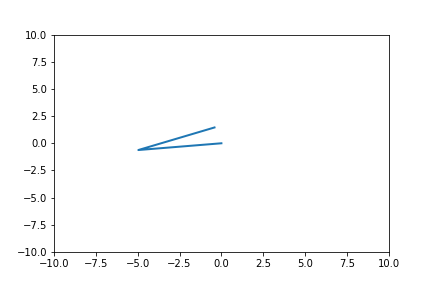
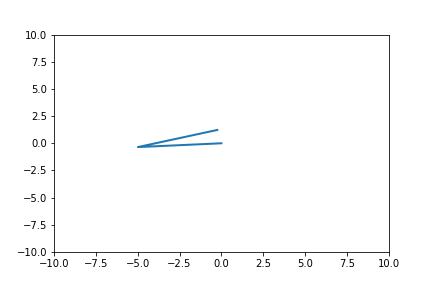
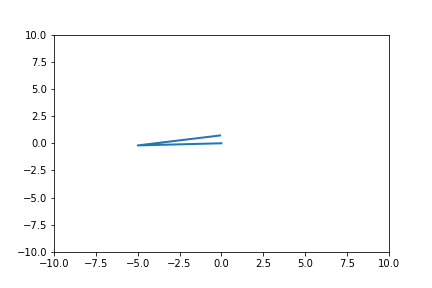
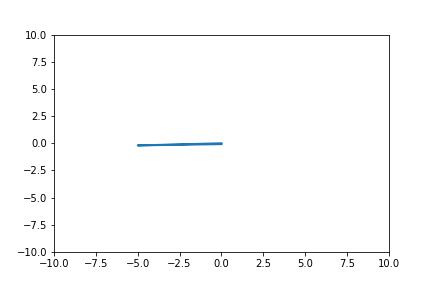
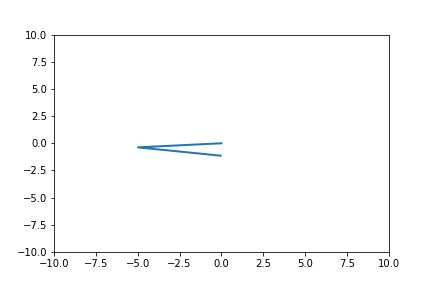
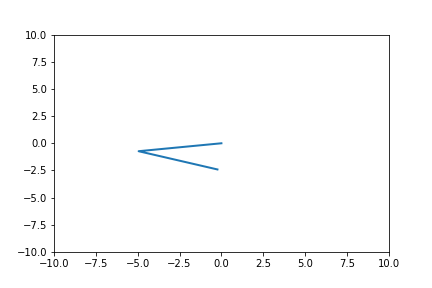
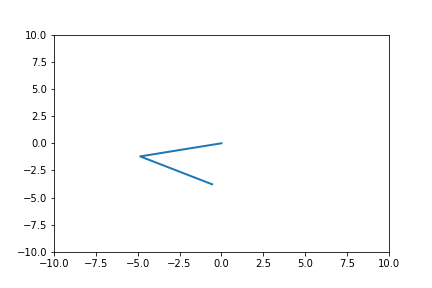
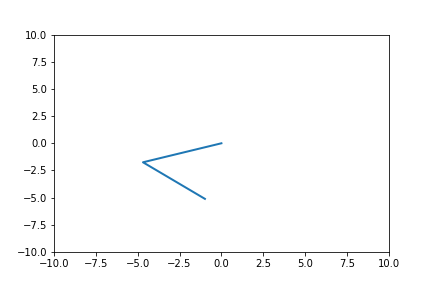
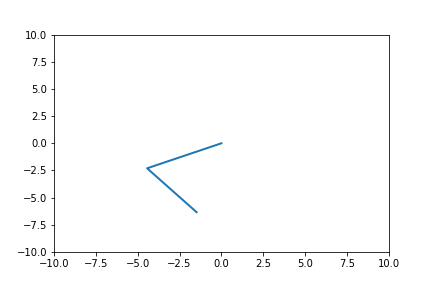
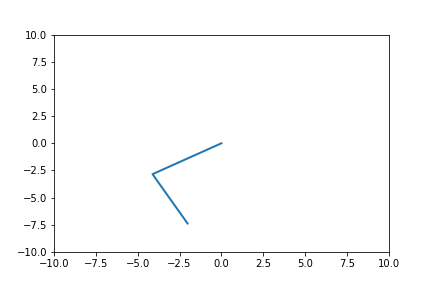
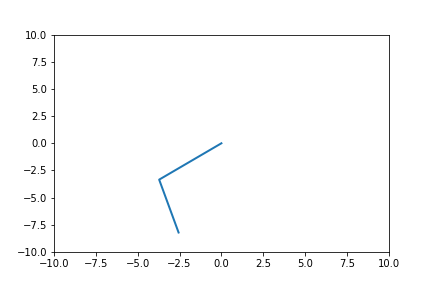
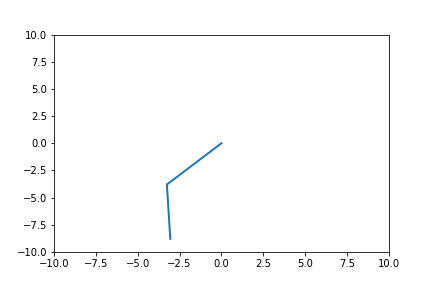
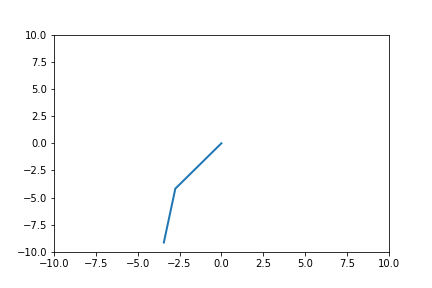
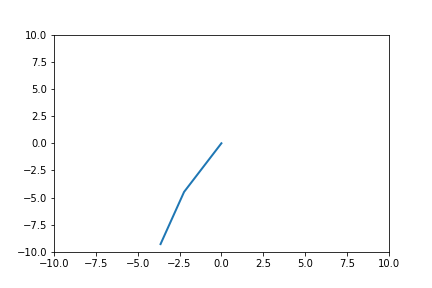
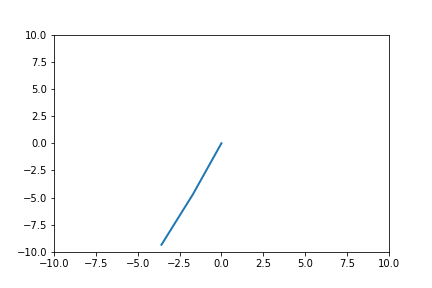
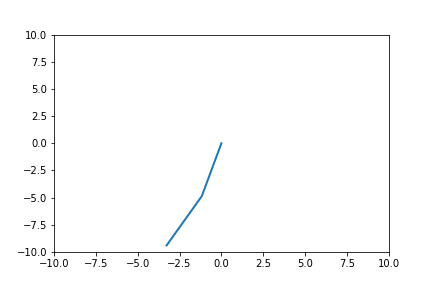
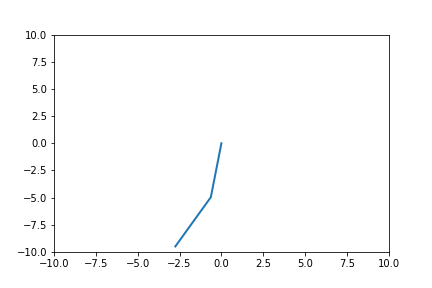
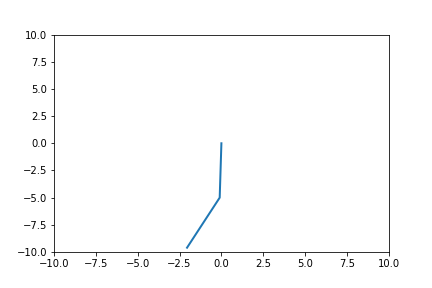
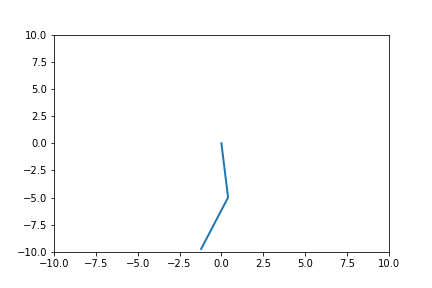
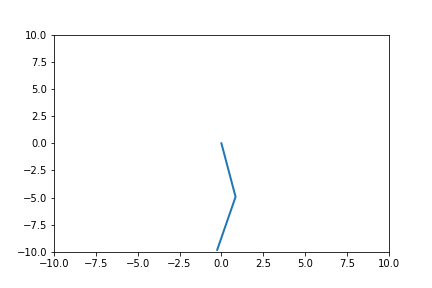
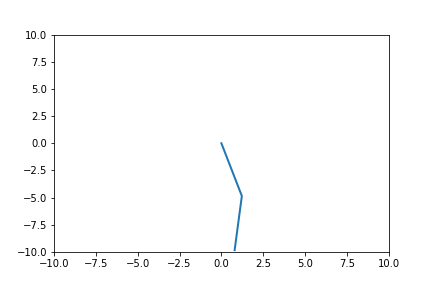
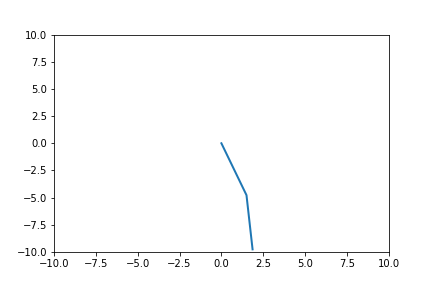
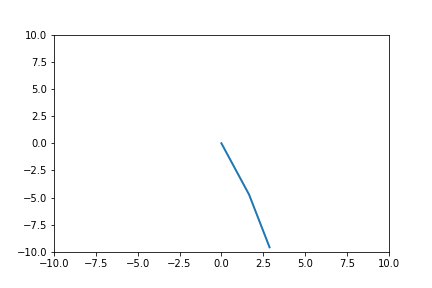
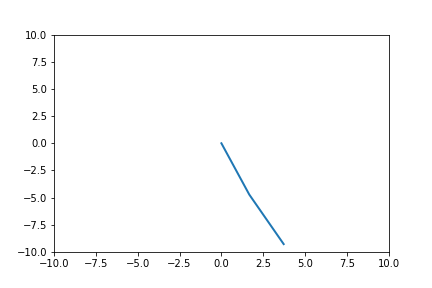
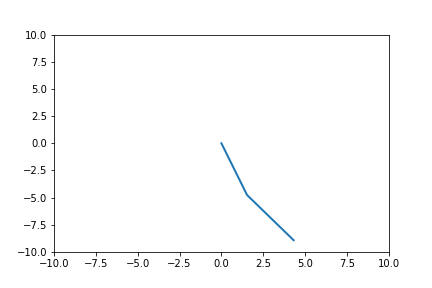
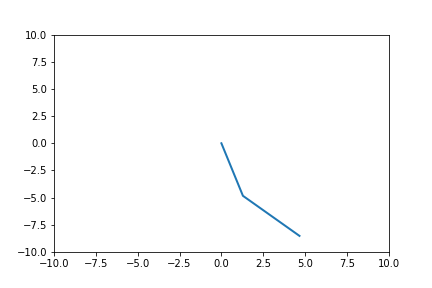
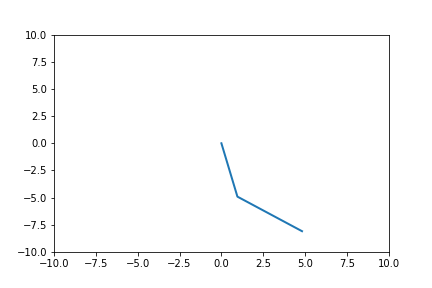
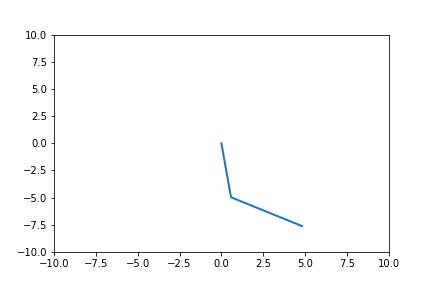
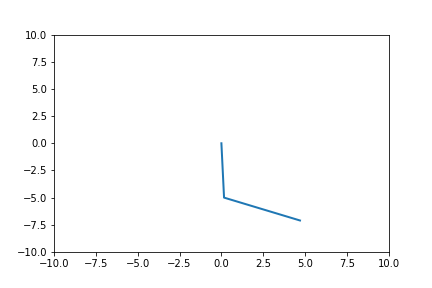
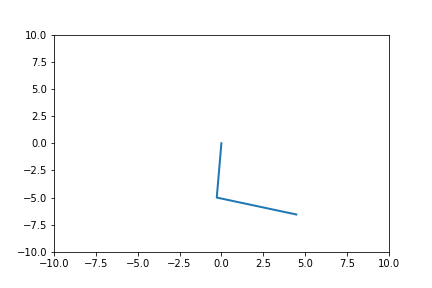
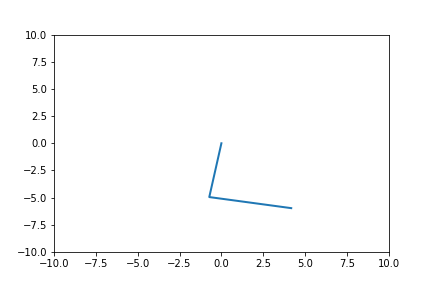
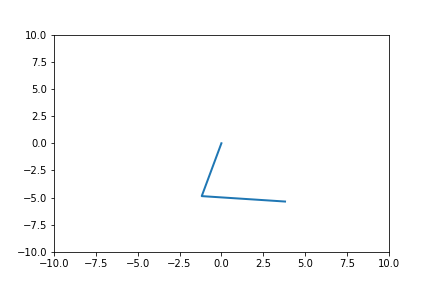
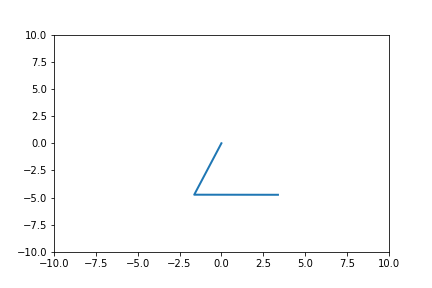
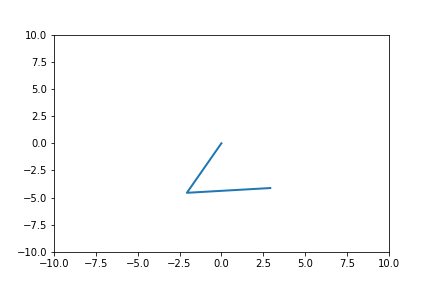
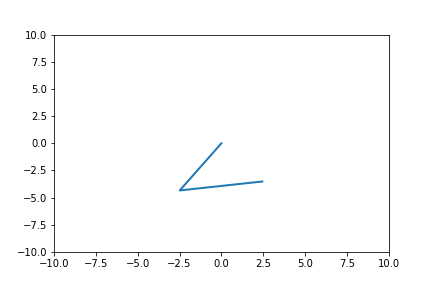
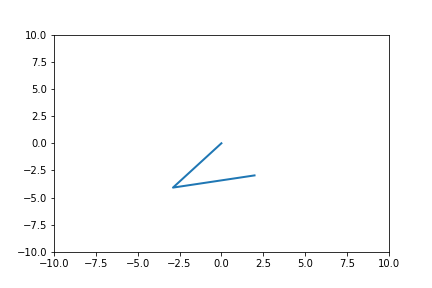
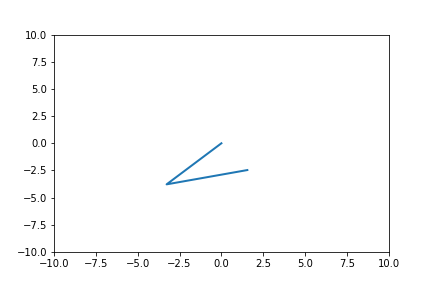
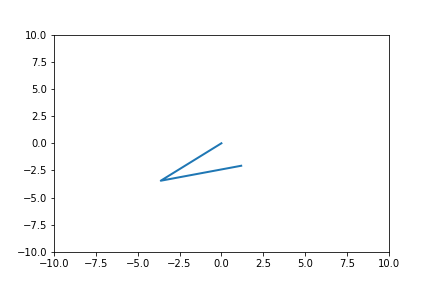
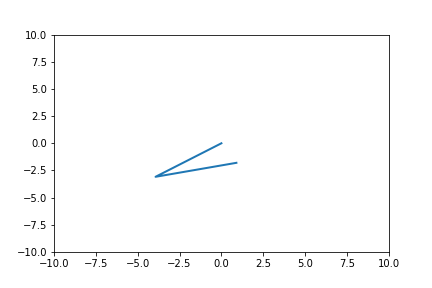
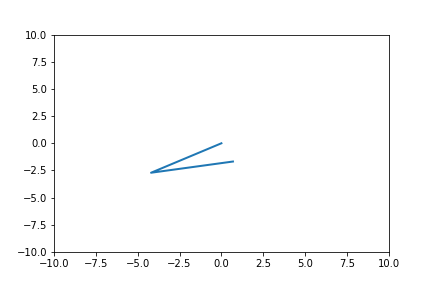
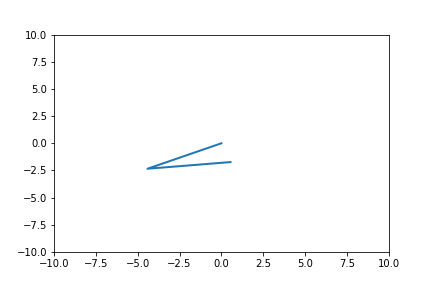
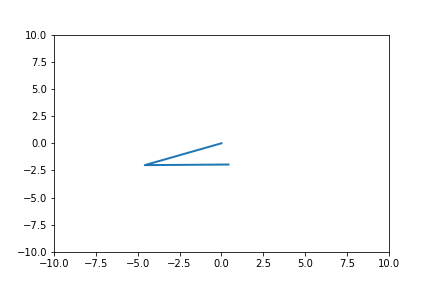
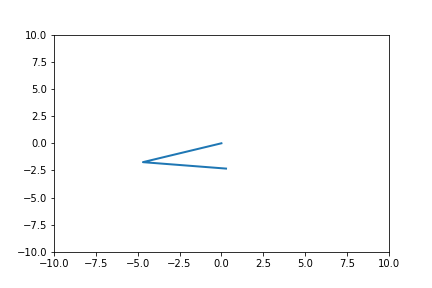
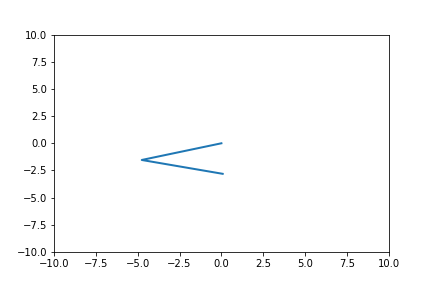
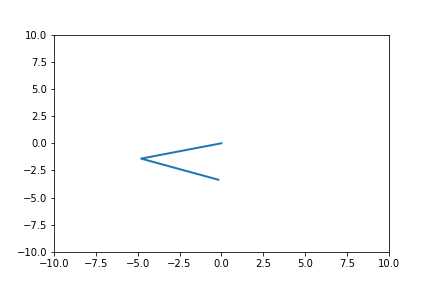
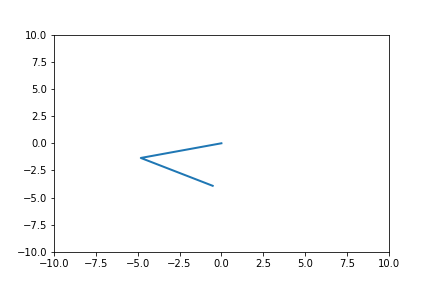
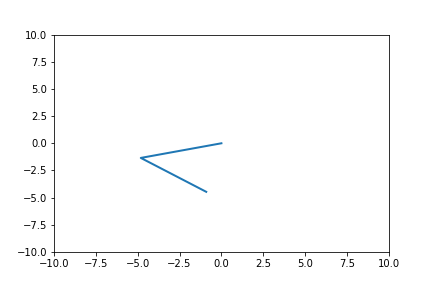
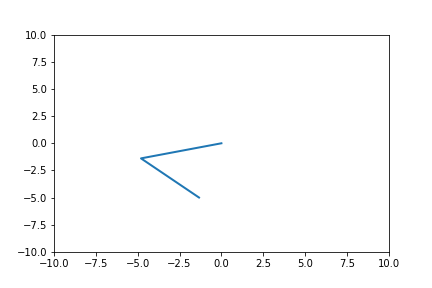
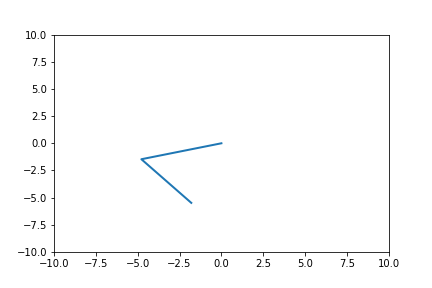
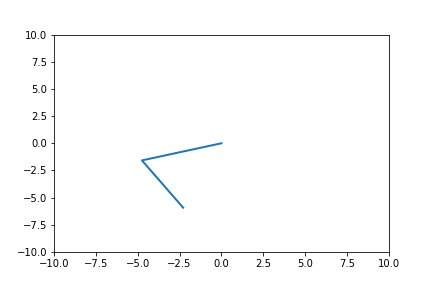
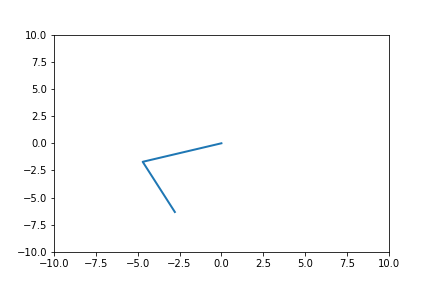
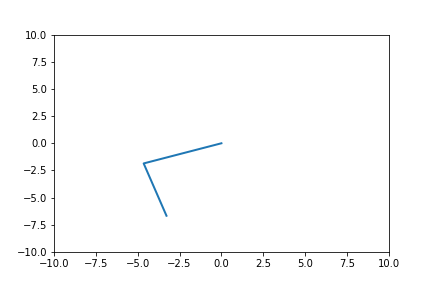
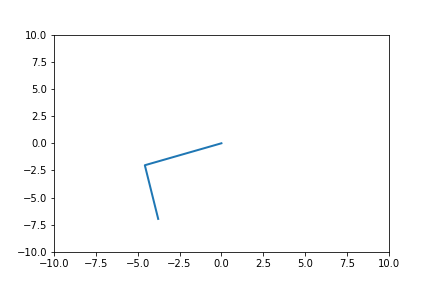
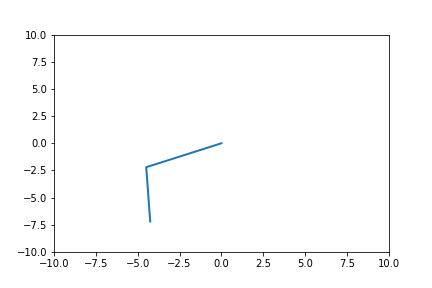
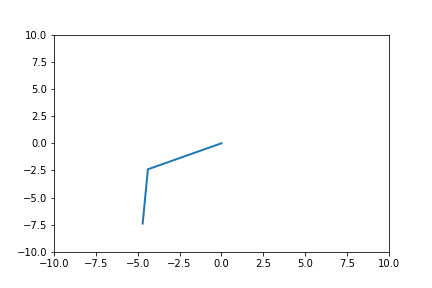
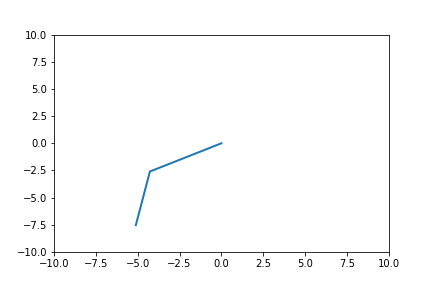
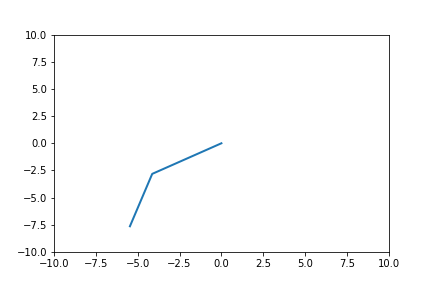
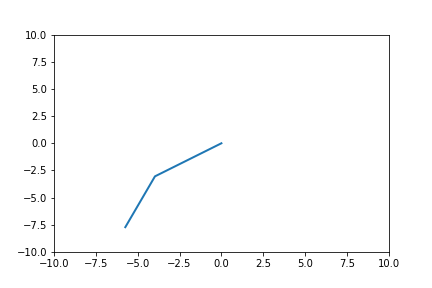
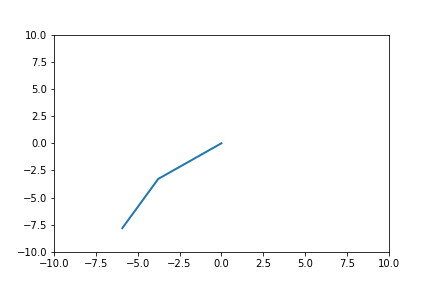
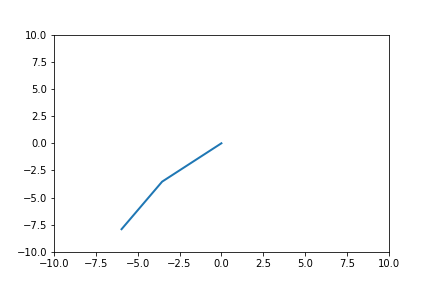
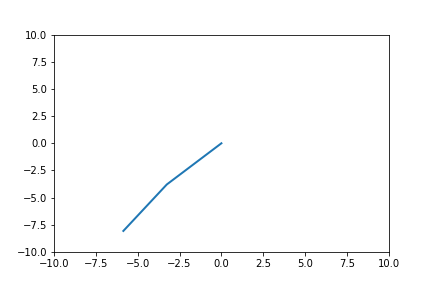
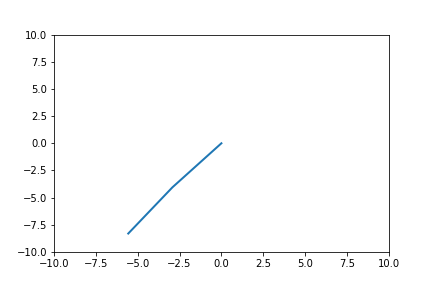
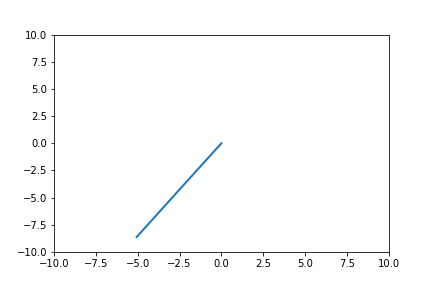
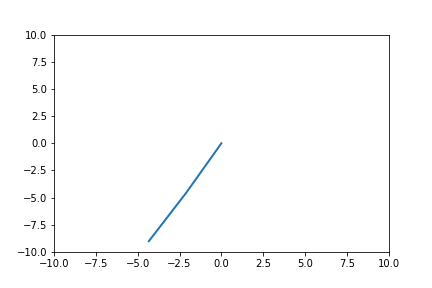
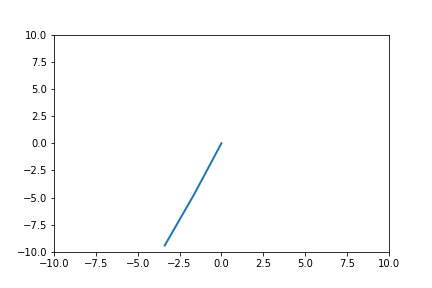
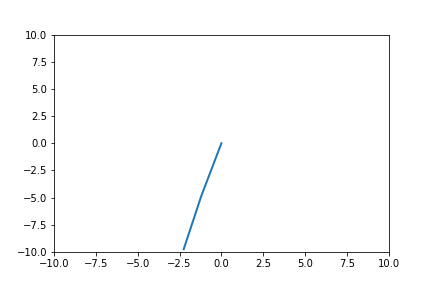
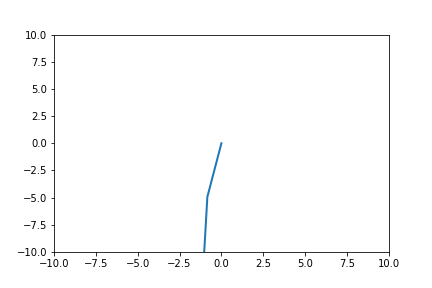
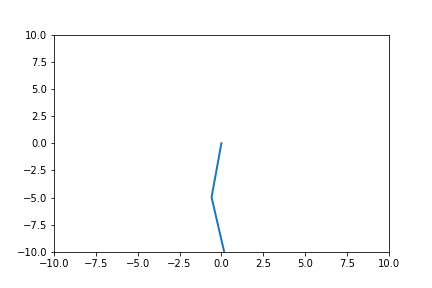
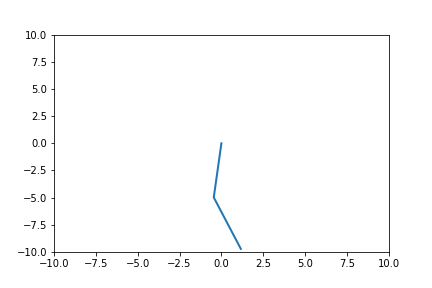
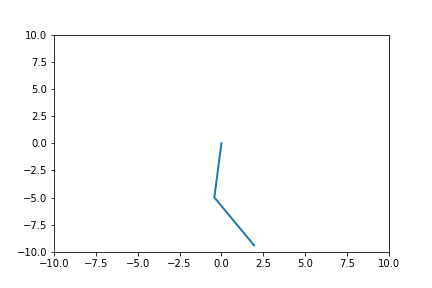
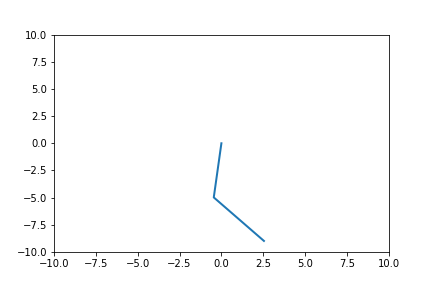
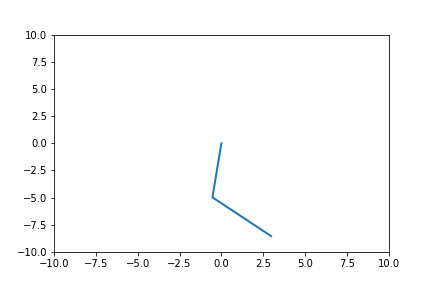
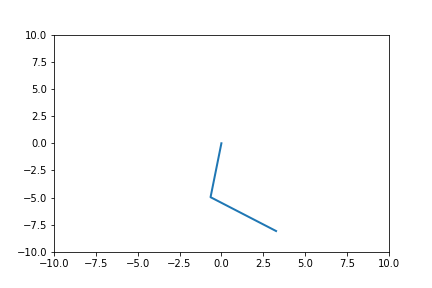
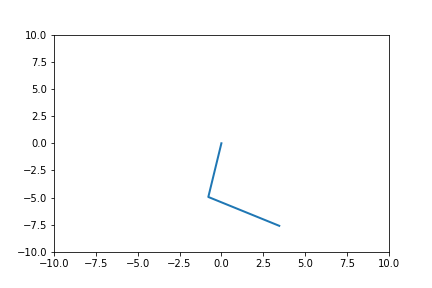
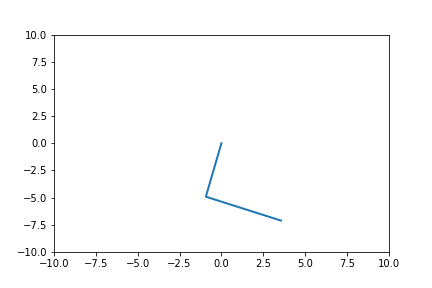
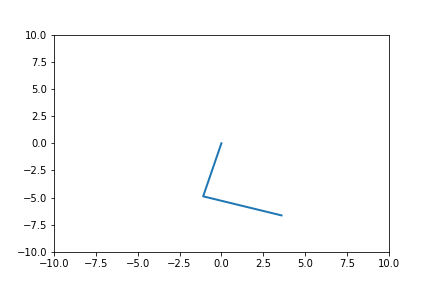
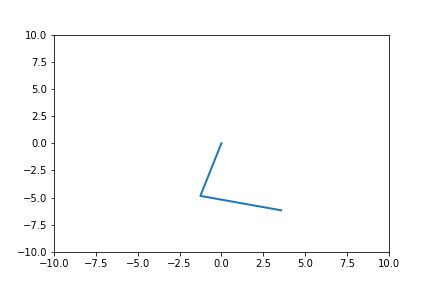
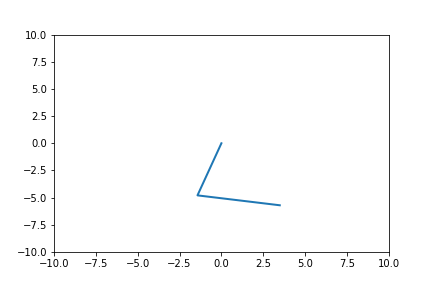
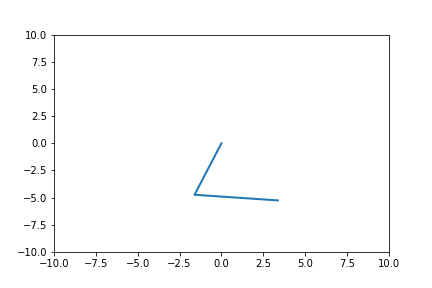
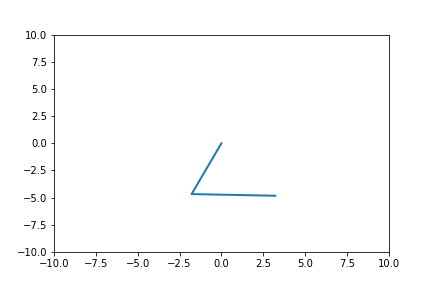
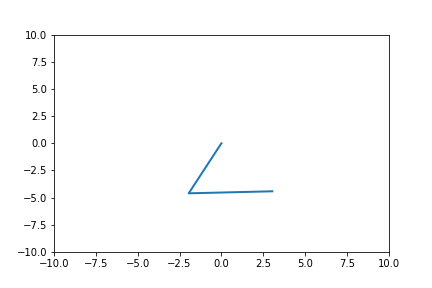
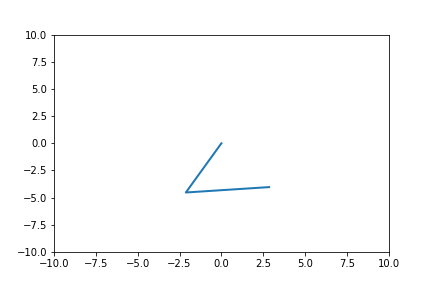
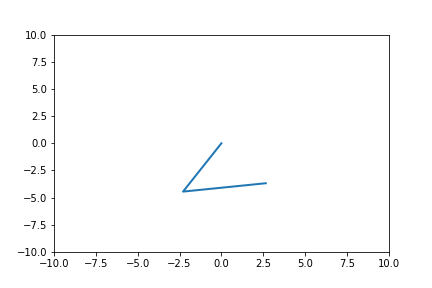
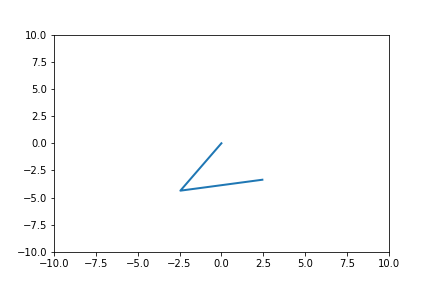
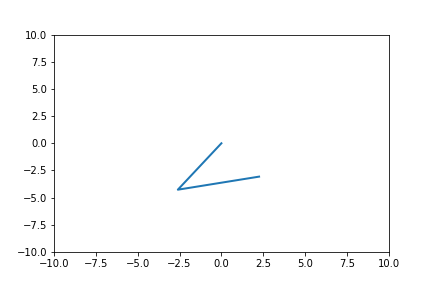
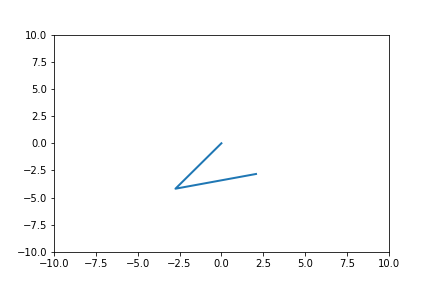
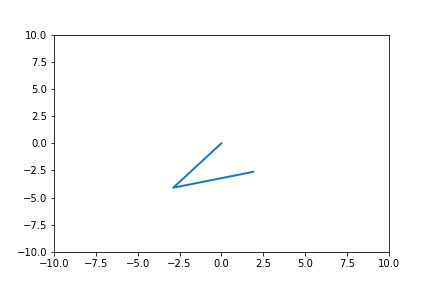
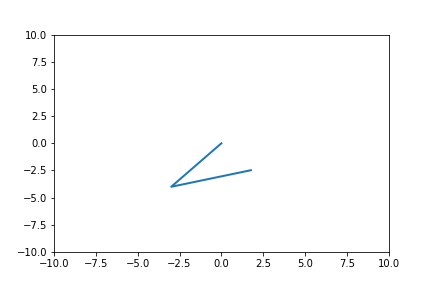
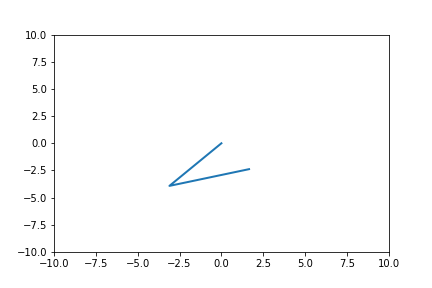
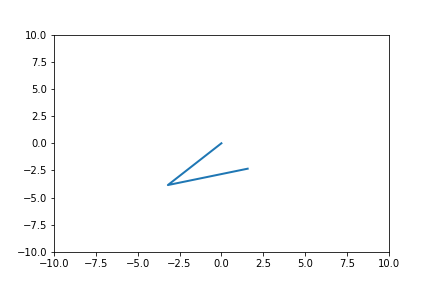
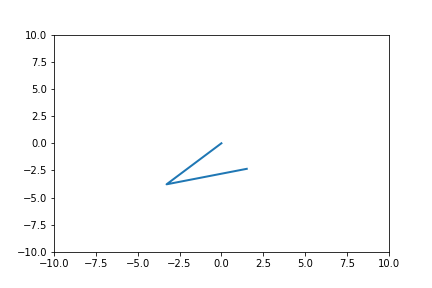
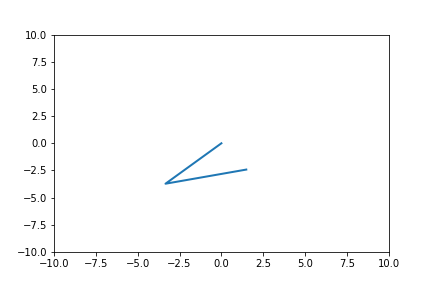
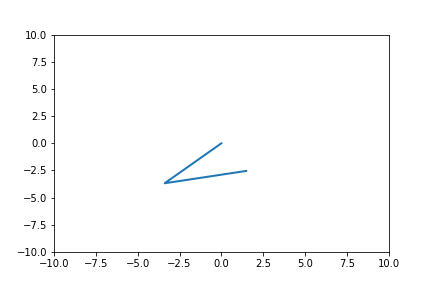
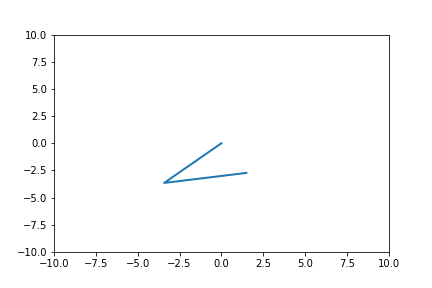
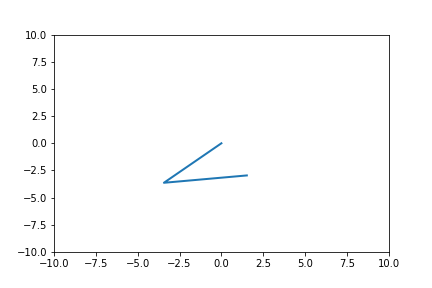
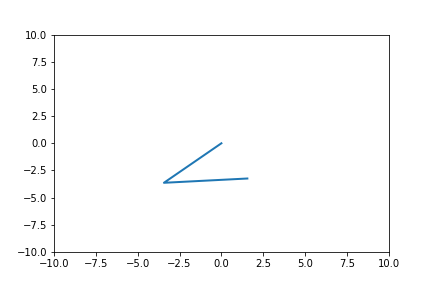
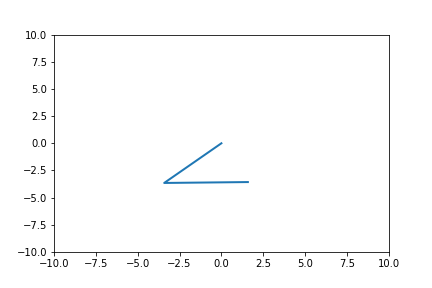
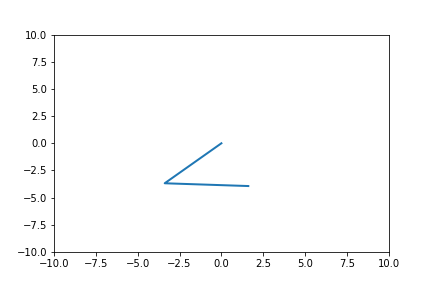
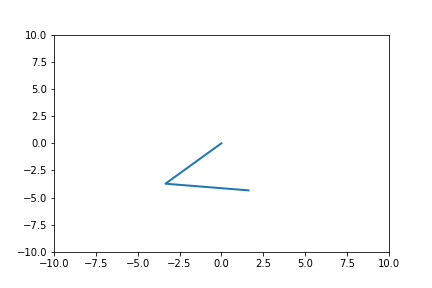
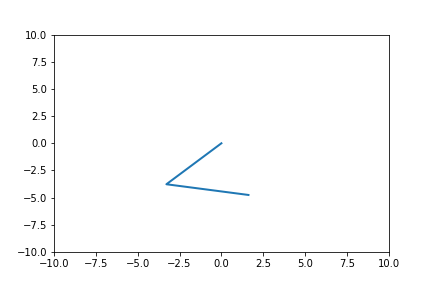
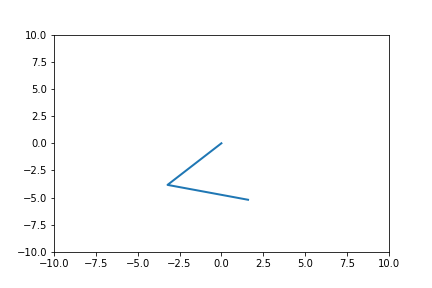
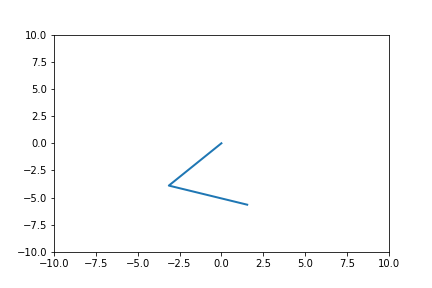
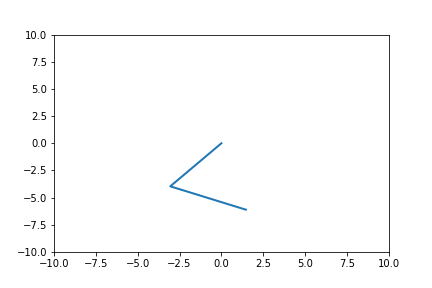
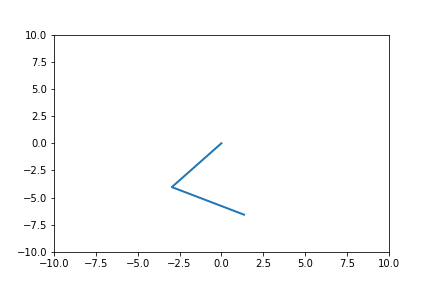
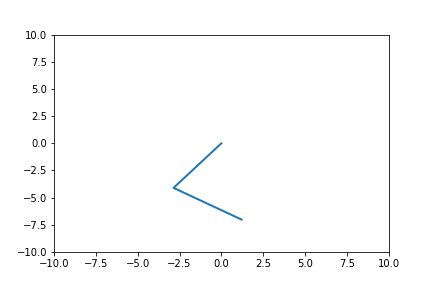
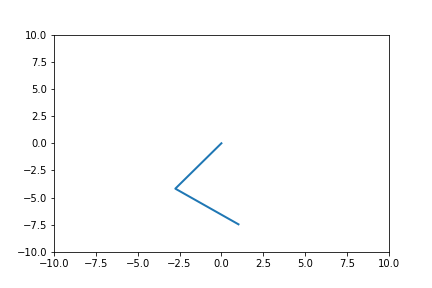
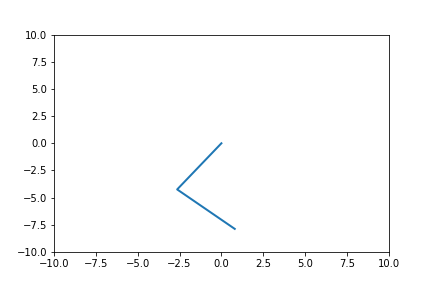
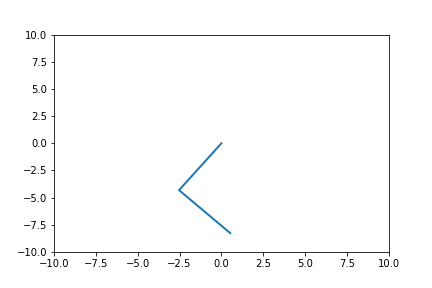
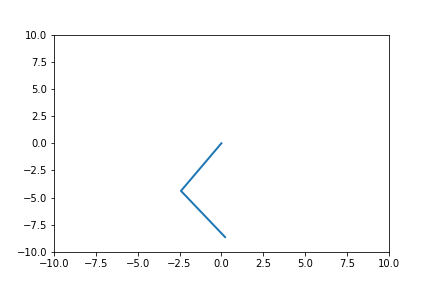
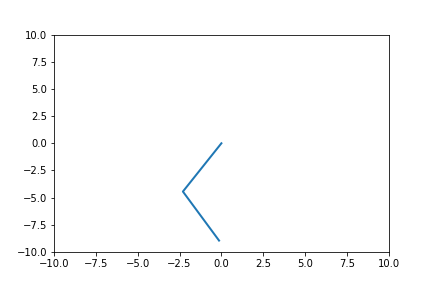
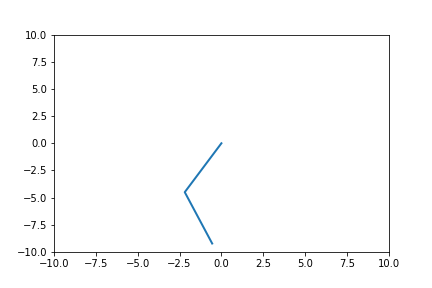
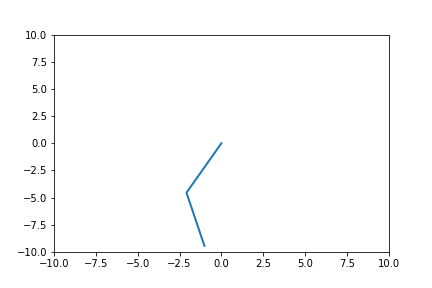
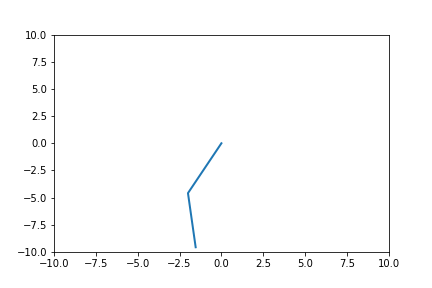
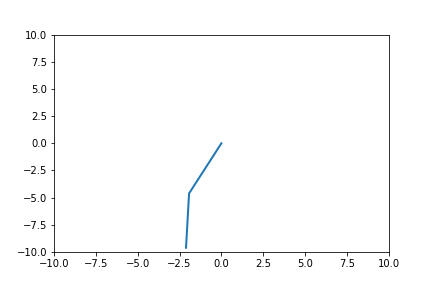
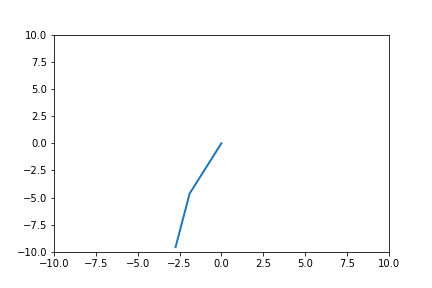
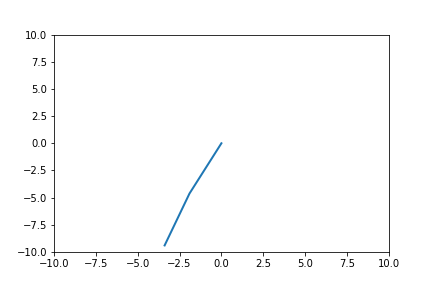
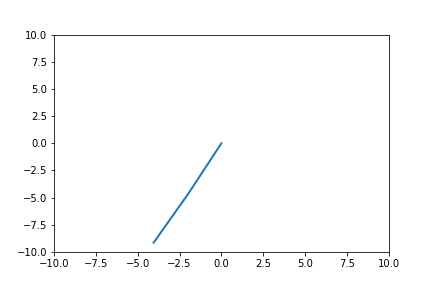
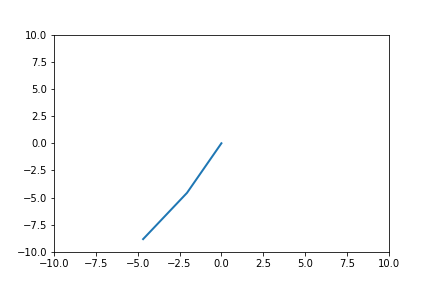
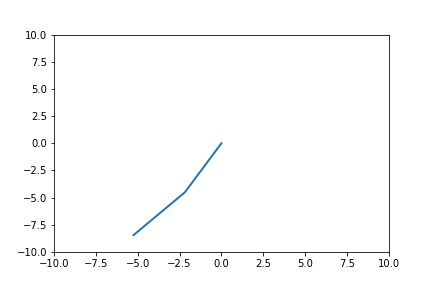
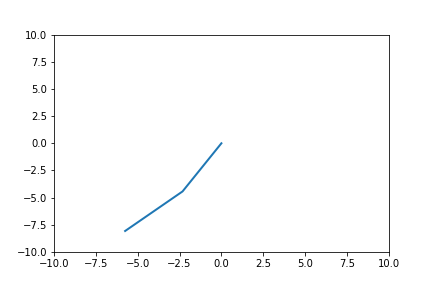
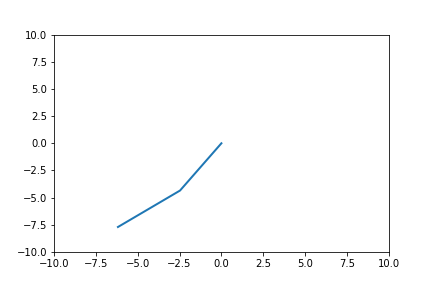
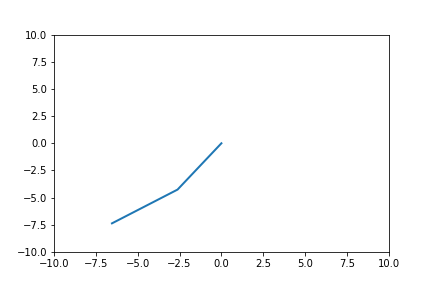
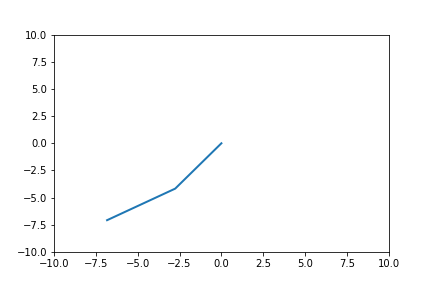
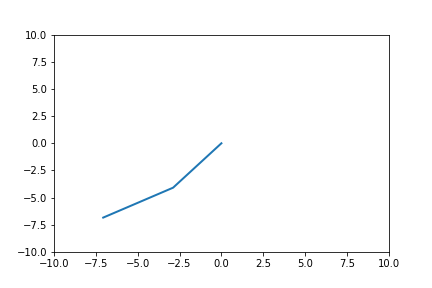
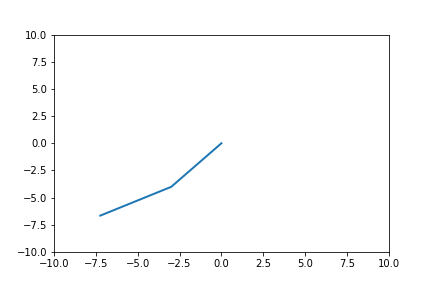
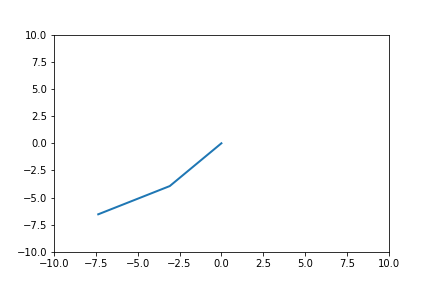
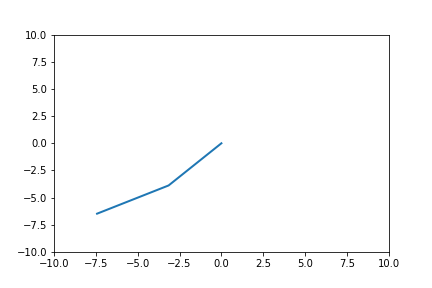
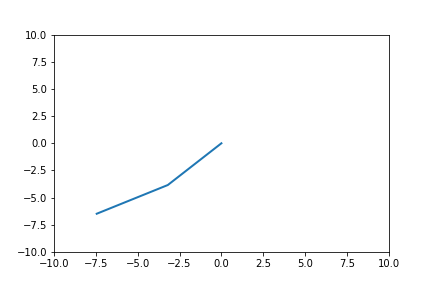
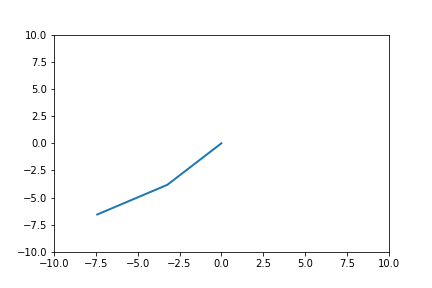
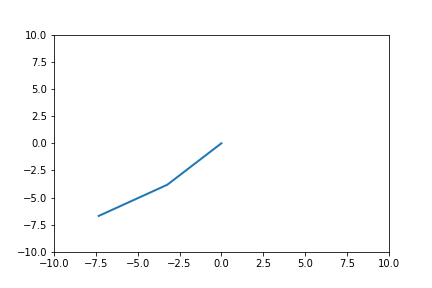
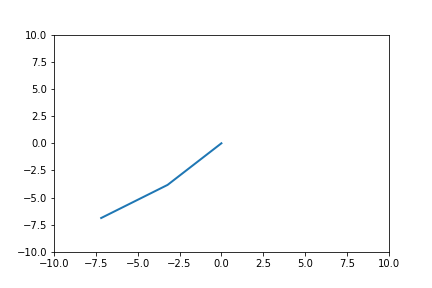
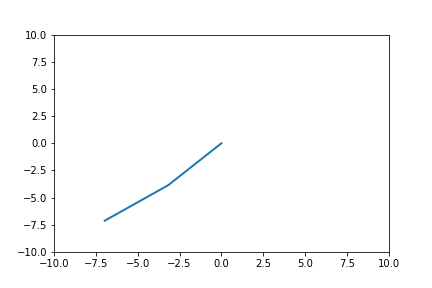
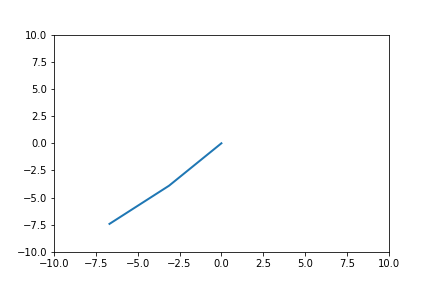
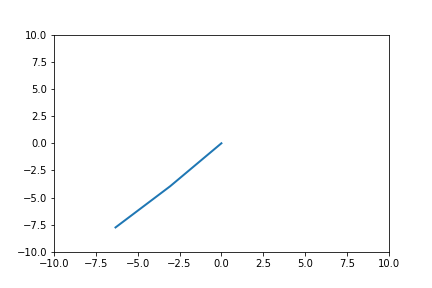
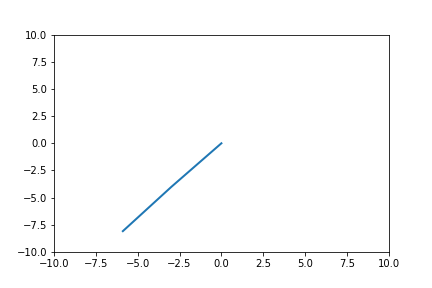

In [422]:
# Lyapunov exponent
display_animation(anim,default_mode='loop')

[[  2.0943951   -0.17453293   0.           0.        ]
 [  2.09096478  -0.17124471  -0.13665808   0.13084603]
 [  2.08073026  -0.16147861  -0.27108853   0.25781588]
 ..., 
 [-11.31671119  -4.18415873  -0.70566223   3.9484324 ]
 [-11.36146602  -3.99795552  -1.05254079   3.50963337]
 [-11.42021796  -3.82988953  -1.27643318   3.21348688]]


In [437]:
a = np.ones([100,4])

print(a[:,0:2])

[[ 1.  1.]
 [ 1.  1.]
 [ 1.  1.]
 [ 1.  1.]
 [ 1.  1.]
 [ 1.  1.]
 [ 1.  1.]
 [ 1.  1.]
 [ 1.  1.]
 [ 1.  1.]
 [ 1.  1.]
 [ 1.  1.]
 [ 1.  1.]
 [ 1.  1.]
 [ 1.  1.]
 [ 1.  1.]
 [ 1.  1.]
 [ 1.  1.]
 [ 1.  1.]
 [ 1.  1.]
 [ 1.  1.]
 [ 1.  1.]
 [ 1.  1.]
 [ 1.  1.]
 [ 1.  1.]
 [ 1.  1.]
 [ 1.  1.]
 [ 1.  1.]
 [ 1.  1.]
 [ 1.  1.]
 [ 1.  1.]
 [ 1.  1.]
 [ 1.  1.]
 [ 1.  1.]
 [ 1.  1.]
 [ 1.  1.]
 [ 1.  1.]
 [ 1.  1.]
 [ 1.  1.]
 [ 1.  1.]
 [ 1.  1.]
 [ 1.  1.]
 [ 1.  1.]
 [ 1.  1.]
 [ 1.  1.]
 [ 1.  1.]
 [ 1.  1.]
 [ 1.  1.]
 [ 1.  1.]
 [ 1.  1.]
 [ 1.  1.]
 [ 1.  1.]
 [ 1.  1.]
 [ 1.  1.]
 [ 1.  1.]
 [ 1.  1.]
 [ 1.  1.]
 [ 1.  1.]
 [ 1.  1.]
 [ 1.  1.]
 [ 1.  1.]
 [ 1.  1.]
 [ 1.  1.]
 [ 1.  1.]
 [ 1.  1.]
 [ 1.  1.]
 [ 1.  1.]
 [ 1.  1.]
 [ 1.  1.]
 [ 1.  1.]
 [ 1.  1.]
 [ 1.  1.]
 [ 1.  1.]
 [ 1.  1.]
 [ 1.  1.]
 [ 1.  1.]
 [ 1.  1.]
 [ 1.  1.]
 [ 1.  1.]
 [ 1.  1.]
 [ 1.  1.]
 [ 1.  1.]
 [ 1.  1.]
 [ 1.  1.]
 [ 1.  1.]
 [ 1.  1.]
 [ 1.  1.]
 [ 1.  1.]
 [ 1.  1.]
 [ 1.  1.]
 [ 1.  1.]